<a href="https://colab.research.google.com/github/dsdelapaz/spam-classifier-neural-network/blob/main/Spam_Tweets_Classifier_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Tweets Classifier using CNN

The goal is to create the a CNN model with the best hyperparameters that can predict whether a tweet is a spam or not.

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import plotly
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.nn.utils.rnn import pad_sequence

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import optuna
import gc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from plotly.io import show

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

### Loading dataset

In [ ]:
# Read data
data = pd.read_csv('/content/drive/MyDrive/Data/twitter spam data.csv')
data.head()

,class,tweets,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Thank u!,NaN,NaN,NaN
1,0,Going for dinner.msg you after.,NaN,NaN,NaN
2,0,Hi i won't b ard 4 christmas. But do enjoy n m...,NaN,NaN,NaN
3,0,1. Tension face 2. Smiling face 3. Waste face ...,NaN,NaN,NaN
4,0,1 I don't have her number and 2 its gonna be a...,NaN,NaN,NaN


### Exploratory data analysis

In [ ]:
data.shape

(5572, 5)

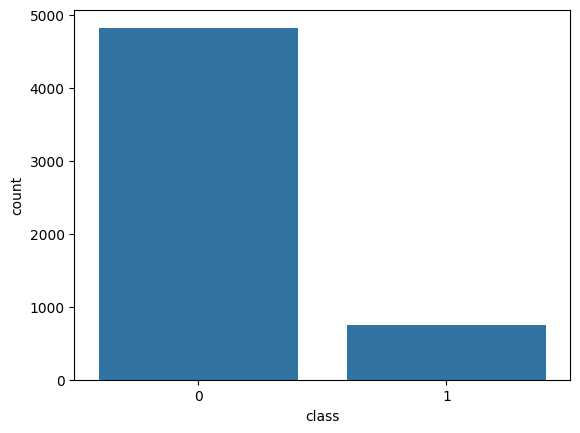

In [ ]:
sns.countplot(x='class', data=data)
plt.show()

In [ ]:
balanced_data = data[['class', 'tweets']]

### Cleaning data

1. Punctuations Removal

In [ ]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['tweets']= balanced_data['tweets'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

/tmp/ipython-input-3718067920.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,class,tweets
0,0,Thank u
1,0,Going for dinnermsg you after
2,0,Hi i wont b ard 4 christmas But do enjoy n mer...
3,0,1 Tension face 2 Smiling face 3 Waste face 4 I...
4,0,1 I dont have her number and 2 its gonna be a ...


2. Stopwords Removal

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

balanced_data['tweets'] = balanced_data['tweets'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

/tmp/ipython-input-3584725390.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,class,tweets
0,0,thank u
1,0,going dinnermsg
2,0,hi wont b ard 4 christmas enjoy n merry xmas
3,0,1 tension face 2 smiling face 3 waste face 4 i...
4,0,1 dont number 2 gonna massive pain ass id rath...


3. Visualization World Cloud

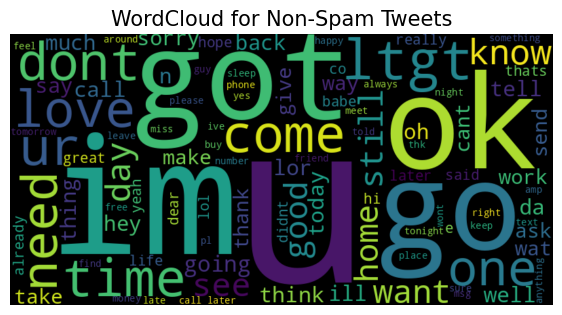

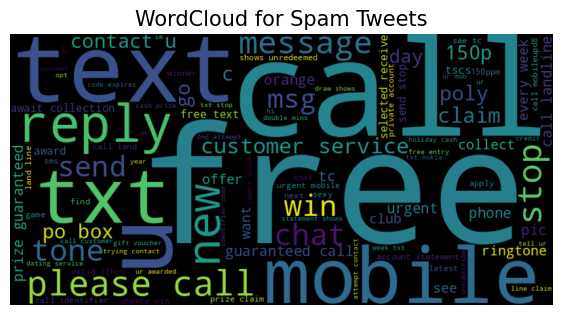

In [ ]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['tweets'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Tweets', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['class'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['class'] == 1], typ='Spam')

### Train, validation, and test split

In [ ]:
# Initial split: Separate the final test set (e.g., 20%)
dev_X, test_X, dev_Y, test_Y = train_test_split(
    balanced_data['tweets'], balanced_data['class'], test_size=0.2, random_state=42
)

# Second split: The test_size here (0.25) is 25% OF the X_dev set.
# 0.25 * 0.80 = 0.20 (20% of the original data)
train_X, val_X, train_Y, val_Y = train_test_split(
    dev_X, dev_Y, test_size=0.25, random_state=42
)

# Training dataset
texts = [text for text in train_X]
labels = train_Y.tolist()

# Validation dataset
val_texts = [text for text in val_X]
val_labels = val_Y.tolist()

# Test dataset
test_texts = [text for text in test_X]
test_labels = test_Y.tolist()

# Check if correctly labeled
ind_start, ind_end = 1, 10
for ind in range(ind_start, ind_end+1):
    print(f'index:{ind}, label: {labels[ind]}, text: {texts[ind]}')

index:1, label: 0, text: great office today
index:2, label: 0, text: belive come home
index:3, label: 0, text: oh thats late well good night give u call tomorrow iam going go sleep night night
index:4, label: 0, text: dont know exactly could ask chechi
index:5, label: 0, text: nothing u dinner w us
index:6, label: 0, text: way office da
index:7, label: 0, text: purity friendship two smiling reading forwarded messageits smiling seeing name gud evng musthu
index:8, label: 0, text: oooh got plenty
index:9, label: 0, text: de asking like
index:10, label: 0, text: moon come color dreams stars make musical sms give warm peaceful sleep good night


### Tokenization and padding

In [ ]:
# Load the spacy model for English
nlp = spacy.load("en_core_web_sm")

# Tokenize text using spacy
def preprocess_text(text):
    doc = nlp(text.lower())
    return [token.text for token in doc if not token.is_punct and not token.is_stop]

tokenized_texts = [preprocess_text(text) for text in texts]
tokenized_val_texts = [preprocess_text(text) for text in val_texts]
tokenized_test_texts = [preprocess_text(text) for text in test_texts]

# Build a vocabulary using a Counter
counter = Counter([token for sublist in tokenized_texts for token in sublist])
vocab = {token: idx for idx, (token, _) in enumerate(counter.items(), start=1)}
vocab["<PAD>"] = 0  # Add padding token
vocab_size = len(vocab)

# Convert tokenized_text into sequences of integers
def text_to_sequence(tokenized_text):
    return [vocab.get(token, vocab["<PAD>"]) for token in tokenized_text]

sequences = [text_to_sequence(text) for text in tokenized_texts]
val_sequences = [text_to_sequence(text) for text in tokenized_val_texts]
test_sequences = [text_to_sequence(text) for text in tokenized_test_texts]

# Pad sequences (tensors now)
padded_sequences = pad_sequence([torch.tensor(seq) for seq in sequences],
                                batch_first=True,
                                padding_value=vocab["<PAD>"])
padded_val_sequences = pad_sequence([torch.tensor(seq) for seq in val_sequences],
                                batch_first=True,
                                padding_value=vocab["<PAD>"])
padded_test_sequences = pad_sequence([torch.tensor(seq) for seq in test_sequences],
                                batch_first=True,
                                padding_value=vocab["<PAD>"])

# Convert labels to tensor
labels = torch.tensor(labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [ ]:
padded_sequences

tensor([[   1,    2,    3,  ...,    0,    0,    0],
        [   4,    5,    6,  ...,    0,    0,    0],
        [   7,    8,    9,  ...,    0,    0,    0],
        ...,
        [  15, 1741, 6833,  ...,    0,    0,    0],
        [ 514,   15,  387,  ...,    0,    0,    0],
        [1819,   39, 6837,  ...,    0,    0,    0]])

In [ ]:
vocab_size

6838

## Model (CNN using PyTorch)

In [ ]:
# Assuming device is set to 'cuda' or 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SpamClasifierCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, dropout_rate):
        super(SpamClasifierCNN, self).__init__()

        # Embedding layer to convert token indices into dense vectors
        # The entries at padding_idx do not contribute to the gradient
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Convolutional layers with different kernel sizes for capturing various n-grams
        self.conv1 = nn.Conv1d(in_channels=embed_size, out_channels=100, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=embed_size, out_channels=100, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=embed_size, out_channels=100, kernel_size=5)

        # Fully connected layer
        # 100 filters per kernel size * 3
        # 2 stands for two classes (1/0)
        self.fc = nn.Linear(300, 2)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Apply embedding layer
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)

        # Change dimension for Conv1d: (batch_size, embed_size, seq_len)
        x = x.permute(0, 2, 1)

        # Apply convolution + activation(ReLU) + max pooling for each filter size
        x1 = F.relu(self.conv1(x))
        x1 = F.max_pool1d(x1, kernel_size=x1.size(2)).squeeze(2)
        x2 = F.relu(self.conv2(x))
        x2 = F.max_pool1d(x2, kernel_size=x2.size(2)).squeeze(2)
        x3 = F.relu(self.conv3(x))
        x3 = F.max_pool1d(x3, kernel_size=x3.size(2)).squeeze(2)

        # Concatenate the outputs from each convolutional branch
        x = torch.cat((x1, x2, x3), dim=1)

        # Apply dropout and pass through the fully connected layer
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Example usage:
embed_size = 100
dropout_rate = 0.5

model = SpamClasifierCNN(vocab_size, embed_size, dropout_rate)
print(model)

SpamClasifierCNN(
  (embedding): Embedding(6838, 100, padding_idx=0)
  (conv1): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  (conv3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
def compute_inverse_weights(labels):
    # `labels` is a 1D tensor containing our labels (0 for ham, 1 for spam)
    num_samples = len(labels)
    num_ham = (labels == 0).sum().item()
    num_spam = (labels == 1).sum().item()

    # Calculate the class weights inversely proportional to class frequency
    weight_ham = num_samples / (2 * num_ham)
    weight_spam = num_samples / (2 * num_spam)

    # Create a tensor of weights for CrossEntropyLoss
    class_weights = torch.tensor([weight_ham, weight_spam], dtype=torch.float).to(device)

    return class_weights

In [ ]:
def compute_evaluation_metrics(model, criterion, val_sequences, val_labels):
    # This function should compute the average validation loss or other metric we optimize on
    model.eval()
    with torch.no_grad():
        logits = model(val_sequences)
        loss = criterion(logits, val_labels)

        # Apply softmax to get class probabilities, and next to get the predicted class
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)

    accuracy = accuracy_score(val_labels, predicted_class)
    precision = precision_score(val_labels, predicted_class, zero_division=0.0)
    recall = recall_score(val_labels, predicted_class, zero_division=0.0)
    f1 = f1_score(val_labels, predicted_class, zero_division=0.0)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return loss

In [ ]:
# Pad sequences (tensors now)
padded_sequences = padded_sequences.to(device)
padded_val_sequences = padded_val_sequences.to(device)
labels = labels.to(device)
test_labels = test_labels.to(device)

# Calculate inverse weights to handle inbalance
class_weights = compute_inverse_weights(labels)

def objective(trial):
    # Suggest hyperparameters, change the range
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    embed_size = trial.suggest_int('embed_size', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.5)

    print(f"Hyperparams:\nlearning_rate:{learning_rate}\nnum_epochs:{num_epochs}")
    print(f"embed_size:{embed_size}\ndropout_rate:{dropout_rate})"

    # Initialize your model with suggested hyperparameters
    model = SpamClasifierCNN(vocab_size, embed_size=embed_size, dropout_rate=dropout_rate)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Early stopping parameters
    patience = 5  # Number of epochs to wait for improvement
    best_loss = float('inf')
    epochs_without_improvement = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        optimizer.zero_grad() # Clear gradients
        outputs = model(padded_sequences) # Forward pass
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the model parameters

        # Validation step
        with torch.no_grad():
            # Compute validation loss (and metric)
            loss = compute_evaluation_metrics(model, criterion, padded_val_sequences, val_labels)
            print(f"epoch: {epoch}, loss: {loss}")

        # Early stopping logic
        if loss < best_loss:
            best_loss = loss
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

        trial.report(loss, epoch)

    # Clear variables and free memory
    del model, optimizer, criterion
    gc.collect()
    torch.cuda.empty_cache()

    # Return the best validation metric or loss
    return best_loss

# Step 3: Create a study and optimize
study = optuna.create_study(direction='minimize')  # Minimize validation loss
study.optimize(objective, n_trials=100)  # Adjust n_trials based on your computational resources, change this one

# Step 4: Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

[I 2025-11-22 14:00:51,655] A new study created in memory with name: no-name-8450c3b5-1626-42b4-b032-fdec43420585


Hyperparams:
learning_rate:2.1852449452191837e-05
num_epochs:23
embed_size:239
dropout_rate:0.09655711354324716
Accuracy: 0.8664, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 0, loss: 0.8310207724571228
Accuracy: 0.8655, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 1, loss: 0.8233866095542908
Accuracy: 0.8628, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 2, loss: 0.8158719539642334
Accuracy: 0.8619, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 3, loss: 0.8084717988967896
Accuracy: 0.8601, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 4, loss: 0.8011905550956726
Accuracy: 0.8592, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 5, loss: 0.7940253615379333
Accuracy: 0.8565, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 6, loss: 0.7869776487350464
Accuracy: 0.8565, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 7, loss: 0.7800518870353699
Accuracy: 0.8565, Precision: 0.0000, Recall: 0.0

[I 2025-11-22 14:01:53,537] Trial 0 finished with value: 0.6910744309425354 and parameters: {'learning_rate': 2.1852449452191837e-05, 'num_epochs': 23, 'embed_size': 239, 'dropout_rate': 0.09655711354324716}. Best is trial 0 with value: 0.6910744309425354.


Hyperparams:
learning_rate:0.0003460783832606708
num_epochs:17
embed_size:66
dropout_rate:0.12240273964280686
Accuracy: 0.5013, Precision: 0.1429, Recall: 0.6489, F1 Score: 0.2342
epoch: 0, loss: 0.6796706318855286
Accuracy: 0.3641, Precision: 0.1378, Recall: 0.8397, F1 Score: 0.2368
epoch: 1, loss: 0.6641168594360352
Accuracy: 0.2771, Precision: 0.1359, Recall: 0.9618, F1 Score: 0.2382
epoch: 2, loss: 0.656264066696167
Accuracy: 0.2314, Precision: 0.1318, Recall: 0.9924, F1 Score: 0.2328
epoch: 3, loss: 0.6519039869308472
Accuracy: 0.2135, Precision: 0.1292, Recall: 0.9924, F1 Score: 0.2287
epoch: 4, loss: 0.6471721529960632
Accuracy: 0.2224, Precision: 0.1313, Recall: 1.0000, F1 Score: 0.2321
epoch: 5, loss: 0.6398570537567139
Accuracy: 0.2493, Precision: 0.1353, Recall: 1.0000, F1 Score: 0.2384
epoch: 6, loss: 0.6295883059501648
Accuracy: 0.2807, Precision: 0.1396, Recall: 0.9924, F1 Score: 0.2448
epoch: 7, loss: 0.6171351671218872
Accuracy: 0.3399, Precision: 0.1503, Recall: 0.9924

[I 2025-11-22 14:02:11,185] Trial 1 finished with value: 0.5232306122779846 and parameters: {'learning_rate': 0.0003460783832606708, 'num_epochs': 17, 'embed_size': 66, 'dropout_rate': 0.12240273964280686}. Best is trial 1 with value: 0.5232306122779846.


Hyperparams:
learning_rate:0.00020747473993303154
num_epochs:34
embed_size:70
dropout_rate:0.2385224798506047
Accuracy: 0.6870, Precision: 0.0045, Recall: 0.0076, F1 Score: 0.0057
epoch: 0, loss: 0.7730175852775574
Accuracy: 0.6251, Precision: 0.0136, Recall: 0.0305, F1 Score: 0.0188
epoch: 1, loss: 0.7459841966629028
Accuracy: 0.5623, Precision: 0.0699, Recall: 0.2214, F1 Score: 0.1062
epoch: 2, loss: 0.7237067818641663
Accuracy: 0.4915, Precision: 0.1148, Recall: 0.4962, F1 Score: 0.1865
epoch: 3, loss: 0.7059949040412903
Accuracy: 0.4215, Precision: 0.1411, Recall: 0.7710, F1 Score: 0.2385
epoch: 4, loss: 0.6925497055053711
Accuracy: 0.3408, Precision: 0.1344, Recall: 0.8473, F1 Score: 0.2320
epoch: 5, loss: 0.6828495860099792
Accuracy: 0.2771, Precision: 0.1336, Recall: 0.9389, F1 Score: 0.2338
epoch: 6, loss: 0.6761763095855713
Accuracy: 0.2430, Precision: 0.1321, Recall: 0.9771, F1 Score: 0.2327
epoch: 7, loss: 0.6716717481613159
Accuracy: 0.2197, Precision: 0.1294, Recall: 0.984

[I 2025-11-22 14:02:47,605] Trial 2 finished with value: 0.5153059363365173 and parameters: {'learning_rate': 0.00020747473993303154, 'num_epochs': 34, 'embed_size': 70, 'dropout_rate': 0.2385224798506047}. Best is trial 2 with value: 0.5153059363365173.


Hyperparams:
learning_rate:0.0001129189581859101
num_epochs:14
embed_size:172
dropout_rate:0.07767281781643445
Accuracy: 0.8323, Precision: 0.0172, Recall: 0.0076, F1 Score: 0.0106
epoch: 0, loss: 0.7383679151535034
Accuracy: 0.8206, Precision: 0.0941, Recall: 0.0611, F1 Score: 0.0741
epoch: 1, loss: 0.7141135931015015
Accuracy: 0.7991, Precision: 0.1556, Recall: 0.1603, F1 Score: 0.1579
epoch: 2, loss: 0.6922604441642761
Accuracy: 0.7794, Precision: 0.1858, Recall: 0.2595, F1 Score: 0.2166
epoch: 3, loss: 0.6727516055107117
Accuracy: 0.7570, Precision: 0.2107, Recall: 0.3893, F1 Score: 0.2735
epoch: 4, loss: 0.6555423140525818
Accuracy: 0.7390, Precision: 0.2531, Recall: 0.6260, F1 Score: 0.3604
epoch: 5, loss: 0.6405381560325623
Accuracy: 0.7085, Precision: 0.2551, Recall: 0.7710, F1 Score: 0.3833
epoch: 6, loss: 0.6275718212127686
Accuracy: 0.6700, Precision: 0.2463, Recall: 0.8779, F1 Score: 0.3846
epoch: 7, loss: 0.6164383888244629
Accuracy: 0.6287, Precision: 0.2294, Recall: 0.91

[I 2025-11-22 14:03:15,769] Trial 3 finished with value: 0.5742074847221375 and parameters: {'learning_rate': 0.0001129189581859101, 'num_epochs': 14, 'embed_size': 172, 'dropout_rate': 0.07767281781643445}. Best is trial 2 with value: 0.5153059363365173.


Hyperparams:
learning_rate:9.431733864579837e-05
num_epochs:44
embed_size:145
dropout_rate:0.4312357677471577
Accuracy: 0.1623, Precision: 0.1223, Recall: 0.9924, F1 Score: 0.2178
epoch: 0, loss: 0.7198466062545776
Accuracy: 0.1695, Precision: 0.1232, Recall: 0.9924, F1 Score: 0.2192
epoch: 1, loss: 0.7072098255157471
Accuracy: 0.1767, Precision: 0.1242, Recall: 0.9924, F1 Score: 0.2207
epoch: 2, loss: 0.695313572883606
Accuracy: 0.1892, Precision: 0.1244, Recall: 0.9771, F1 Score: 0.2207
epoch: 3, loss: 0.684073805809021
Accuracy: 0.2027, Precision: 0.1255, Recall: 0.9695, F1 Score: 0.2222
epoch: 4, loss: 0.6735385656356812
Accuracy: 0.2287, Precision: 0.1292, Recall: 0.9695, F1 Score: 0.2280
epoch: 5, loss: 0.6637541651725769
Accuracy: 0.2493, Precision: 0.1323, Recall: 0.9695, F1 Score: 0.2328
epoch: 6, loss: 0.6546313762664795
Accuracy: 0.2726, Precision: 0.1360, Recall: 0.9695, F1 Score: 0.2385
epoch: 7, loss: 0.6461594104766846
Accuracy: 0.3058, Precision: 0.1408, Recall: 0.9618,

[I 2025-11-22 14:04:42,700] Trial 4 finished with value: 0.4789397418498993 and parameters: {'learning_rate': 9.431733864579837e-05, 'num_epochs': 44, 'embed_size': 145, 'dropout_rate': 0.4312357677471577}. Best is trial 4 with value: 0.4789397418498993.


Hyperparams:
learning_rate:0.0045224094261282375
num_epochs:22
embed_size:154
dropout_rate:0.4357741580063496
Accuracy: 0.1444, Precision: 0.1207, Recall: 1.0000, F1 Score: 0.2155
epoch: 0, loss: 0.9719920754432678
Accuracy: 0.6664, Precision: 0.2585, Recall: 0.9847, F1 Score: 0.4095
epoch: 1, loss: 0.42586275935173035
Accuracy: 0.9238, Precision: 0.7054, Recall: 0.6031, F1 Score: 0.6502
epoch: 2, loss: 0.4624127745628357
Accuracy: 0.9309, Precision: 0.7455, Recall: 0.6260, F1 Score: 0.6805
epoch: 3, loss: 0.45288366079330444
Accuracy: 0.9265, Precision: 0.6623, Recall: 0.7634, F1 Score: 0.7092
epoch: 4, loss: 0.3061556816101074
Accuracy: 0.9049, Precision: 0.5604, Recall: 0.8855, F1 Score: 0.6864
epoch: 5, loss: 0.2411094307899475
Accuracy: 0.8637, Precision: 0.4613, Recall: 0.9542, F1 Score: 0.6219
epoch: 6, loss: 0.2422834187746048
Accuracy: 0.8457, Precision: 0.4305, Recall: 0.9695, F1 Score: 0.5962
epoch: 7, loss: 0.25082483887672424
Accuracy: 0.8547, Precision: 0.4456, Recall: 0.

[I 2025-11-22 14:05:15,561] Trial 5 finished with value: 0.18404614925384521 and parameters: {'learning_rate': 0.0045224094261282375, 'num_epochs': 22, 'embed_size': 154, 'dropout_rate': 0.4357741580063496}. Best is trial 5 with value: 0.18404614925384521.


Hyperparams:
learning_rate:0.0042262284641063795
num_epochs:33
embed_size:112
dropout_rate:0.16422945735068945
Accuracy: 0.1193, Precision: 0.1177, Recall: 1.0000, F1 Score: 0.2106
epoch: 0, loss: 0.9610805511474609
Accuracy: 0.1865, Precision: 0.1262, Recall: 1.0000, F1 Score: 0.2241
epoch: 1, loss: 0.7120829820632935
Accuracy: 0.7067, Precision: 0.2812, Recall: 0.9618, F1 Score: 0.4352
epoch: 2, loss: 0.43275365233421326
Accuracy: 0.9166, Precision: 0.6532, Recall: 0.6183, F1 Score: 0.6353
epoch: 3, loss: 0.44829583168029785
Accuracy: 0.9229, Precision: 0.7320, Recall: 0.5420, F1 Score: 0.6228
epoch: 4, loss: 0.48237112164497375
Accuracy: 0.9327, Precision: 0.7188, Recall: 0.7023, F1 Score: 0.7104
epoch: 5, loss: 0.3896118402481079
Accuracy: 0.9220, Precision: 0.6264, Recall: 0.8321, F1 Score: 0.7148
epoch: 6, loss: 0.2975250780582428
Accuracy: 0.8924, Precision: 0.5240, Recall: 0.9160, F1 Score: 0.6667
epoch: 7, loss: 0.26605361700057983
Accuracy: 0.8619, Precision: 0.4579, Recall: 

[I 2025-11-22 14:05:42,573] Trial 6 finished with value: 0.19991815090179443 and parameters: {'learning_rate': 0.0042262284641063795, 'num_epochs': 33, 'embed_size': 112, 'dropout_rate': 0.16422945735068945}. Best is trial 5 with value: 0.18404614925384521.


Hyperparams:
learning_rate:0.0009348695935380033
num_epochs:43
embed_size:184
dropout_rate:0.23590029315097977
Accuracy: 0.3453, Precision: 0.1505, Recall: 0.9847, F1 Score: 0.2611
epoch: 0, loss: 0.6379587650299072
Accuracy: 0.2861, Precision: 0.1405, Recall: 0.9924, F1 Score: 0.2462
epoch: 1, loss: 0.6052901744842529
Accuracy: 0.3973, Precision: 0.1623, Recall: 0.9924, F1 Score: 0.2790
epoch: 2, loss: 0.5552712082862854
Accuracy: 0.5973, Precision: 0.2230, Recall: 0.9771, F1 Score: 0.3631
epoch: 3, loss: 0.49341246485710144
Accuracy: 0.7498, Precision: 0.3150, Recall: 0.9618, F1 Score: 0.4746
epoch: 4, loss: 0.44013461470603943
Accuracy: 0.8395, Precision: 0.4167, Recall: 0.9160, F1 Score: 0.5728
epoch: 5, loss: 0.4036949574947357
Accuracy: 0.8753, Precision: 0.4832, Recall: 0.8779, F1 Score: 0.6233
epoch: 6, loss: 0.381509006023407
Accuracy: 0.8933, Precision: 0.5286, Recall: 0.8473, F1 Score: 0.6510
epoch: 7, loss: 0.364692360162735
Accuracy: 0.9022, Precision: 0.5556, Recall: 0.83

[I 2025-11-22 14:07:17,132] Trial 7 finished with value: 0.17578069865703583 and parameters: {'learning_rate': 0.0009348695935380033, 'num_epochs': 43, 'embed_size': 184, 'dropout_rate': 0.23590029315097977}. Best is trial 7 with value: 0.17578069865703583.


Hyperparams:
learning_rate:1.6460962662919338e-05
num_epochs:49
embed_size:48
dropout_rate:0.37269242047472473
Accuracy: 0.8152, Precision: 0.0588, Recall: 0.0382, F1 Score: 0.0463
epoch: 0, loss: 0.7262210845947266
Accuracy: 0.8090, Precision: 0.0543, Recall: 0.0382, F1 Score: 0.0448
epoch: 1, loss: 0.7243015170097351
Accuracy: 0.8063, Precision: 0.0526, Recall: 0.0382, F1 Score: 0.0442
epoch: 2, loss: 0.7224116921424866
Accuracy: 0.8045, Precision: 0.0606, Recall: 0.0458, F1 Score: 0.0522
epoch: 3, loss: 0.7205508947372437
Accuracy: 0.8027, Precision: 0.0594, Recall: 0.0458, F1 Score: 0.0517
epoch: 4, loss: 0.7187181711196899
Accuracy: 0.8009, Precision: 0.0748, Recall: 0.0611, F1 Score: 0.0672
epoch: 5, loss: 0.7169132232666016
Accuracy: 0.7982, Precision: 0.0727, Recall: 0.0611, F1 Score: 0.0664
epoch: 6, loss: 0.7151352763175964
Accuracy: 0.7955, Precision: 0.0708, Recall: 0.0611, F1 Score: 0.0656
epoch: 7, loss: 0.7133846879005432
Accuracy: 0.7937, Precision: 0.0769, Recall: 0.06

[I 2025-11-22 14:07:58,871] Trial 8 finished with value: 0.6644195914268494 and parameters: {'learning_rate': 1.6460962662919338e-05, 'num_epochs': 49, 'embed_size': 48, 'dropout_rate': 0.37269242047472473}. Best is trial 7 with value: 0.17578069865703583.


Hyperparams:
learning_rate:0.006251106983452185
num_epochs:33
embed_size:76
dropout_rate:0.39096669767685893
Accuracy: 0.8825, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 0, loss: 1.3041859865188599
Accuracy: 0.8933, Precision: 0.5326, Recall: 0.7481, F1 Score: 0.6222
epoch: 1, loss: 0.4390682578086853
Accuracy: 0.4018, Precision: 0.1642, Recall: 1.0000, F1 Score: 0.2820
epoch: 2, loss: 0.5956593155860901
Accuracy: 0.3596, Precision: 0.1550, Recall: 1.0000, F1 Score: 0.2684
epoch: 3, loss: 0.699950098991394
Accuracy: 0.5202, Precision: 0.1949, Recall: 0.9847, F1 Score: 0.3253
epoch: 4, loss: 0.5449960231781006
Accuracy: 0.7435, Precision: 0.3114, Recall: 0.9771, F1 Score: 0.4723
epoch: 5, loss: 0.3409053683280945
Accuracy: 0.9031, Precision: 0.5545, Recall: 0.8931, F1 Score: 0.6842
epoch: 6, loss: 0.26329559087753296
Accuracy: 0.9345, Precision: 0.7197, Recall: 0.7252, F1 Score: 0.7224
epoch: 7, loss: 0.32315993309020996
Accuracy: 0.9426, Precision: 0.8131, Recall: 0.664

[I 2025-11-22 14:08:27,648] Trial 9 finished with value: 0.16317440569400787 and parameters: {'learning_rate': 0.006251106983452185, 'num_epochs': 33, 'embed_size': 76, 'dropout_rate': 0.39096669767685893}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.007746565744194312
num_epochs:6
embed_size:96
dropout_rate:0.3304734885973775
Accuracy: 0.1175, Precision: 0.1175, Recall: 1.0000, F1 Score: 0.2103
epoch: 0, loss: 1.6818208694458008
Accuracy: 0.3614, Precision: 0.1554, Recall: 1.0000, F1 Score: 0.2690
epoch: 1, loss: 0.6326255202293396
Accuracy: 0.9049, Precision: 0.6068, Recall: 0.5420, F1 Score: 0.5726
epoch: 2, loss: 0.5003777742385864
Accuracy: 0.8987, Precision: 0.6324, Recall: 0.3282, F1 Score: 0.4322
epoch: 3, loss: 0.6442809700965881
Accuracy: 0.9283, Precision: 0.6809, Recall: 0.7328, F1 Score: 0.7059
epoch: 4, loss: 0.35627275705337524
Accuracy: 0.8969, Precision: 0.5367, Recall: 0.8931, F1 Score: 0.6705
epoch: 5, loss: 0.24215005338191986


[I 2025-11-22 14:08:35,276] Trial 10 finished with value: 0.24215005338191986 and parameters: {'learning_rate': 0.007746565744194312, 'num_epochs': 6, 'embed_size': 96, 'dropout_rate': 0.3304734885973775}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0012818010371064652
num_epochs:39
embed_size:204
dropout_rate:0.2269268990711802
Accuracy: 0.7112, Precision: 0.2630, Recall: 0.8092, F1 Score: 0.3970
epoch: 0, loss: 0.5890633463859558
Accuracy: 0.6592, Precision: 0.2544, Recall: 0.9847, F1 Score: 0.4044
epoch: 1, loss: 0.5057041049003601
Accuracy: 0.7256, Precision: 0.2979, Recall: 0.9847, F1 Score: 0.4574
epoch: 2, loss: 0.4482279419898987
Accuracy: 0.8135, Precision: 0.3815, Recall: 0.9466, F1 Score: 0.5439
epoch: 3, loss: 0.39258626103401184
Accuracy: 0.8843, Precision: 0.5045, Recall: 0.8626, F1 Score: 0.6366
epoch: 4, loss: 0.3510875701904297
Accuracy: 0.9103, Precision: 0.5795, Recall: 0.8626, F1 Score: 0.6933
epoch: 5, loss: 0.3229832053184509
Accuracy: 0.9148, Precision: 0.5947, Recall: 0.8626, F1 Score: 0.7040
epoch: 6, loss: 0.2993500828742981
Accuracy: 0.9220, Precision: 0.6209, Recall: 0.8626, F1 Score: 0.7220
epoch: 7, loss: 0.27667146921157837
Accuracy: 0.9238, Precision: 0.6264, Recall: 0.8

[I 2025-11-22 14:09:21,532] Trial 11 finished with value: 0.2007235288619995 and parameters: {'learning_rate': 0.0012818010371064652, 'num_epochs': 39, 'embed_size': 204, 'dropout_rate': 0.2269268990711802}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.001235021601562627
num_epochs:31
embed_size:188
dropout_rate:0.49591357434319205
Accuracy: 0.2206, Precision: 0.1310, Recall: 1.0000, F1 Score: 0.2317
epoch: 0, loss: 0.6369485259056091
Accuracy: 0.4350, Precision: 0.1704, Recall: 0.9847, F1 Score: 0.2905
epoch: 1, loss: 0.5434834361076355
Accuracy: 0.7336, Precision: 0.2995, Recall: 0.9466, F1 Score: 0.4550
epoch: 2, loss: 0.45913034677505493
Accuracy: 0.8664, Precision: 0.4651, Recall: 0.9160, F1 Score: 0.6170
epoch: 3, loss: 0.40927812457084656
Accuracy: 0.8870, Precision: 0.5115, Recall: 0.8473, F1 Score: 0.6379
epoch: 4, loss: 0.3789195120334625
Accuracy: 0.8996, Precision: 0.5473, Recall: 0.8397, F1 Score: 0.6627
epoch: 5, loss: 0.3510402739048004
Accuracy: 0.9022, Precision: 0.5529, Recall: 0.8779, F1 Score: 0.6785
epoch: 6, loss: 0.32355940341949463
Accuracy: 0.8978, Precision: 0.5388, Recall: 0.9008, F1 Score: 0.6743
epoch: 7, loss: 0.3008955717086792
Accuracy: 0.8924, Precision: 0.5242, Recall: 0.

[I 2025-11-22 14:10:27,753] Trial 12 finished with value: 0.19941486418247223 and parameters: {'learning_rate': 0.001235021601562627, 'num_epochs': 31, 'embed_size': 188, 'dropout_rate': 0.49591357434319205}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0013879893223930839
num_epochs:42
embed_size:227
dropout_rate:0.3059878158606471
Accuracy: 0.7991, Precision: 0.3309, Recall: 0.6947, F1 Score: 0.4483
epoch: 0, loss: 0.5825228095054626
Accuracy: 0.4457, Precision: 0.1714, Recall: 0.9695, F1 Score: 0.2913
epoch: 1, loss: 0.5499693155288696
Accuracy: 0.4323, Precision: 0.1680, Recall: 0.9695, F1 Score: 0.2864
epoch: 2, loss: 0.5428099632263184
Accuracy: 0.5516, Precision: 0.2039, Recall: 0.9695, F1 Score: 0.3369
epoch: 3, loss: 0.487292617559433
Accuracy: 0.7058, Precision: 0.2806, Recall: 0.9618, F1 Score: 0.4345
epoch: 4, loss: 0.41097381711006165
Accuracy: 0.8305, Precision: 0.4052, Recall: 0.9466, F1 Score: 0.5675
epoch: 5, loss: 0.34555724263191223
Accuracy: 0.8942, Precision: 0.5284, Recall: 0.9237, F1 Score: 0.6722
epoch: 6, loss: 0.30532780289649963
Accuracy: 0.9247, Precision: 0.6313, Recall: 0.8626, F1 Score: 0.7290
epoch: 7, loss: 0.28925004601478577
Accuracy: 0.9354, Precision: 0.6879, Recall: 0.

[I 2025-11-22 14:11:46,885] Trial 13 finished with value: 0.1943884640932083 and parameters: {'learning_rate': 0.0013879893223930839, 'num_epochs': 42, 'embed_size': 227, 'dropout_rate': 0.3059878158606471}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0006242766231461206
num_epochs:50
embed_size:119
dropout_rate:0.1945320732979961
Accuracy: 0.7767, Precision: 0.0725, Recall: 0.0763, F1 Score: 0.0743
epoch: 0, loss: 0.7280818223953247
Accuracy: 0.6305, Precision: 0.1965, Recall: 0.6947, F1 Score: 0.3064
epoch: 1, loss: 0.6534274220466614
Accuracy: 0.3686, Precision: 0.1519, Recall: 0.9542, F1 Score: 0.2621
epoch: 2, loss: 0.6237253546714783
Accuracy: 0.2439, Precision: 0.1337, Recall: 0.9924, F1 Score: 0.2357
epoch: 3, loss: 0.61857670545578
Accuracy: 0.2206, Precision: 0.1303, Recall: 0.9924, F1 Score: 0.2303
epoch: 4, loss: 0.6165496706962585
Accuracy: 0.2332, Precision: 0.1329, Recall: 1.0000, F1 Score: 0.2346
epoch: 5, loss: 0.6068980693817139
Accuracy: 0.2700, Precision: 0.1386, Recall: 1.0000, F1 Score: 0.2435
epoch: 6, loss: 0.5871509909629822
Accuracy: 0.3417, Precision: 0.1506, Recall: 0.9924, F1 Score: 0.2616
epoch: 7, loss: 0.559669554233551
Accuracy: 0.4520, Precision: 0.1748, Recall: 0.9847, 

[I 2025-11-22 14:13:03,002] Trial 14 finished with value: 0.22612600028514862 and parameters: {'learning_rate': 0.0006242766231461206, 'num_epochs': 50, 'embed_size': 119, 'dropout_rate': 0.1945320732979961}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.009609426275162642
num_epochs:37
embed_size:207
dropout_rate:0.28153019409725283
Accuracy: 0.1381, Precision: 0.1200, Recall: 1.0000, F1 Score: 0.2142
epoch: 0, loss: 2.0518569946289062
Accuracy: 0.6610, Precision: 0.2545, Recall: 0.9771, F1 Score: 0.4038
epoch: 1, loss: 0.4311073124408722
Accuracy: 0.9283, Precision: 0.8400, Recall: 0.4809, F1 Score: 0.6117
epoch: 2, loss: 0.7712734937667847
Accuracy: 0.9489, Precision: 0.8854, Recall: 0.6489, F1 Score: 0.7489
epoch: 3, loss: 0.5305545330047607
Accuracy: 0.9453, Precision: 0.7215, Recall: 0.8702, F1 Score: 0.7889
epoch: 4, loss: 0.22982515394687653
Accuracy: 0.9085, Precision: 0.5662, Recall: 0.9466, F1 Score: 0.7086
epoch: 5, loss: 0.2023591250181198
Accuracy: 0.8726, Precision: 0.4791, Recall: 0.9618, F1 Score: 0.6396
epoch: 6, loss: 0.2449306696653366
Accuracy: 0.8520, Precision: 0.4406, Recall: 0.9618, F1 Score: 0.6043
epoch: 7, loss: 0.2673148214817047
Accuracy: 0.8744, Precision: 0.4828, Recall: 0.96

[I 2025-11-22 14:13:44,354] Trial 15 finished with value: 0.17148897051811218 and parameters: {'learning_rate': 0.009609426275162642, 'num_epochs': 37, 'embed_size': 207, 'dropout_rate': 0.28153019409725283}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.007692509723059587
num_epochs:27
embed_size:216
dropout_rate:0.37020251774474117
Accuracy: 0.1372, Precision: 0.1199, Recall: 1.0000, F1 Score: 0.2141
epoch: 0, loss: 1.600084900856018
Accuracy: 0.6484, Precision: 0.2495, Recall: 0.9924, F1 Score: 0.3988
epoch: 1, loss: 0.43324872851371765
Accuracy: 0.9040, Precision: 0.5923, Recall: 0.5878, F1 Score: 0.5900
epoch: 2, loss: 0.5774309039115906
Accuracy: 0.9202, Precision: 0.6909, Recall: 0.5802, F1 Score: 0.6307
epoch: 3, loss: 0.596548855304718
Accuracy: 0.9265, Precision: 0.6561, Recall: 0.7863, F1 Score: 0.7153
epoch: 4, loss: 0.3433997929096222
Accuracy: 0.9139, Precision: 0.5888, Recall: 0.8855, F1 Score: 0.7073
epoch: 5, loss: 0.2458583116531372
Accuracy: 0.8888, Precision: 0.5152, Recall: 0.9084, F1 Score: 0.6575
epoch: 6, loss: 0.24139678478240967
Accuracy: 0.8753, Precision: 0.4841, Recall: 0.9313, F1 Score: 0.6371
epoch: 7, loss: 0.25389525294303894
Accuracy: 0.8744, Precision: 0.4824, Recall: 0.93

[I 2025-11-22 14:14:25,169] Trial 16 finished with value: 0.21110127866268158 and parameters: {'learning_rate': 0.007692509723059587, 'num_epochs': 27, 'embed_size': 216, 'dropout_rate': 0.37020251774474117}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0026254483789390688
num_epochs:36
embed_size:35
dropout_rate:0.30646999612813475
Accuracy: 0.1193, Precision: 0.1177, Recall: 1.0000, F1 Score: 0.2106
epoch: 0, loss: 0.8013073801994324
Accuracy: 0.1211, Precision: 0.1179, Recall: 1.0000, F1 Score: 0.2110
epoch: 1, loss: 0.733397364616394
Accuracy: 0.3103, Precision: 0.1391, Recall: 0.9389, F1 Score: 0.2424
epoch: 2, loss: 0.6305543184280396
Accuracy: 0.7955, Precision: 0.3249, Recall: 0.6870, F1 Score: 0.4412
epoch: 3, loss: 0.6090158224105835
Accuracy: 0.8386, Precision: 0.3600, Recall: 0.4809, F1 Score: 0.4118
epoch: 4, loss: 0.6013612151145935
Accuracy: 0.8395, Precision: 0.4000, Recall: 0.7328, F1 Score: 0.5175
epoch: 5, loss: 0.5583855509757996
Accuracy: 0.7399, Precision: 0.2956, Recall: 0.8779, F1 Score: 0.4423
epoch: 6, loss: 0.5220984220504761
Accuracy: 0.6000, Precision: 0.2202, Recall: 0.9466, F1 Score: 0.3573
epoch: 7, loss: 0.5150817036628723
Accuracy: 0.5507, Precision: 0.2016, Recall: 0.9542

[I 2025-11-22 14:14:50,917] Trial 17 finished with value: 0.21484720706939697 and parameters: {'learning_rate': 0.0026254483789390688, 'num_epochs': 36, 'embed_size': 35, 'dropout_rate': 0.30646999612813475}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.009854082115267428
num_epochs:26
embed_size:95
dropout_rate:0.3756063841161604
Accuracy: 0.1175, Precision: 0.1175, Recall: 1.0000, F1 Score: 0.2103
epoch: 0, loss: 2.1904449462890625
Accuracy: 0.1632, Precision: 0.1231, Recall: 1.0000, F1 Score: 0.2192
epoch: 1, loss: 1.183862328529358
Accuracy: 0.8439, Precision: 0.4183, Recall: 0.8397, F1 Score: 0.5584
epoch: 2, loss: 0.3574315905570984
Accuracy: 0.9004, Precision: 0.7273, Recall: 0.2443, F1 Score: 0.3657
epoch: 3, loss: 0.8334043622016907
Accuracy: 0.9184, Precision: 0.7941, Recall: 0.4122, F1 Score: 0.5427
epoch: 4, loss: 0.6717080473899841
Accuracy: 0.9300, Precision: 0.6710, Recall: 0.7939, F1 Score: 0.7273
epoch: 5, loss: 0.3161860406398773
Accuracy: 0.8637, Precision: 0.4607, Recall: 0.9389, F1 Score: 0.6181
epoch: 6, loss: 0.26151883602142334
Accuracy: 0.7641, Precision: 0.3299, Recall: 0.9771, F1 Score: 0.4933
epoch: 7, loss: 0.34585410356521606
Accuracy: 0.7390, Precision: 0.3077, Recall: 0.9771

[I 2025-11-22 14:15:13,937] Trial 18 finished with value: 0.18269513547420502 and parameters: {'learning_rate': 0.009854082115267428, 'num_epochs': 26, 'embed_size': 95, 'dropout_rate': 0.3756063841161604}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0029371803380617996
num_epochs:38
embed_size:251
dropout_rate:0.4375127102320693
Accuracy: 0.2090, Precision: 0.1293, Recall: 1.0000, F1 Score: 0.2290
epoch: 0, loss: 0.7319830656051636
Accuracy: 0.7372, Precision: 0.3043, Recall: 0.9618, F1 Score: 0.4624
epoch: 1, loss: 0.38384202122688293
Accuracy: 0.9283, Precision: 0.6735, Recall: 0.7557, F1 Score: 0.7122
epoch: 2, loss: 0.35461750626564026
Accuracy: 0.9381, Precision: 0.7583, Recall: 0.6947, F1 Score: 0.7251
epoch: 3, loss: 0.35919684171676636
Accuracy: 0.9444, Precision: 0.7379, Recall: 0.8168, F1 Score: 0.7754
epoch: 4, loss: 0.2826431393623352
Accuracy: 0.9363, Precision: 0.6765, Recall: 0.8779, F1 Score: 0.7641
epoch: 5, loss: 0.2278769612312317
Accuracy: 0.9247, Precision: 0.6205, Recall: 0.9237, F1 Score: 0.7423
epoch: 6, loss: 0.20821771025657654
Accuracy: 0.9157, Precision: 0.5885, Recall: 0.9389, F1 Score: 0.7235
epoch: 7, loss: 0.2029605209827423
Accuracy: 0.9130, Precision: 0.5802, Recall: 0

[I 2025-11-22 14:16:01,880] Trial 19 finished with value: 0.177701935172081 and parameters: {'learning_rate': 0.0029371803380617996, 'num_epochs': 38, 'embed_size': 251, 'dropout_rate': 0.4375127102320693}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.002170690624487236
num_epochs:31
embed_size:121
dropout_rate:0.2685607665236281
Accuracy: 0.1749, Precision: 0.1239, Recall: 0.9924, F1 Score: 0.2203
epoch: 0, loss: 0.6773985624313354
Accuracy: 0.3327, Precision: 0.1489, Recall: 0.9924, F1 Score: 0.2590
epoch: 1, loss: 0.58245450258255
Accuracy: 0.7238, Precision: 0.2927, Recall: 0.9542, F1 Score: 0.4480
epoch: 2, loss: 0.46518629789352417
Accuracy: 0.8861, Precision: 0.5096, Recall: 0.8092, F1 Score: 0.6254
epoch: 3, loss: 0.4223155975341797
Accuracy: 0.9157, Precision: 0.6164, Recall: 0.7481, F1 Score: 0.6759
epoch: 4, loss: 0.4112313687801361
Accuracy: 0.9184, Precision: 0.6266, Recall: 0.7557, F1 Score: 0.6851
epoch: 5, loss: 0.37763693928718567
Accuracy: 0.9094, Precision: 0.5815, Recall: 0.8168, F1 Score: 0.6794
epoch: 6, loss: 0.33275339007377625
Accuracy: 0.9004, Precision: 0.5472, Recall: 0.8855, F1 Score: 0.6764
epoch: 7, loss: 0.30032193660736084
Accuracy: 0.8906, Precision: 0.5193, Recall: 0.92

[I 2025-11-22 14:16:33,536] Trial 20 finished with value: 0.22026948630809784 and parameters: {'learning_rate': 0.002170690624487236, 'num_epochs': 31, 'embed_size': 121, 'dropout_rate': 0.2685607665236281}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0007864139450287524
num_epochs:44
embed_size:177
dropout_rate:0.16278646074659336
Accuracy: 0.5211, Precision: 0.1827, Recall: 0.8855, F1 Score: 0.3029
epoch: 0, loss: 0.6320854425430298
Accuracy: 0.3274, Precision: 0.1487, Recall: 1.0000, F1 Score: 0.2589
epoch: 1, loss: 0.5964545011520386
Accuracy: 0.3426, Precision: 0.1516, Recall: 1.0000, F1 Score: 0.2633
epoch: 2, loss: 0.569949746131897
Accuracy: 0.4484, Precision: 0.1756, Recall: 1.0000, F1 Score: 0.2987
epoch: 3, loss: 0.5300328731536865
Accuracy: 0.5857, Precision: 0.2200, Recall: 0.9924, F1 Score: 0.3601
epoch: 4, loss: 0.4838535189628601
Accuracy: 0.7229, Precision: 0.2940, Recall: 0.9695, F1 Score: 0.4512
epoch: 5, loss: 0.44222286343574524
Accuracy: 0.8242, Precision: 0.3948, Recall: 0.9313, F1 Score: 0.5545
epoch: 6, loss: 0.41090697050094604
Accuracy: 0.8610, Precision: 0.4535, Recall: 0.8931, F1 Score: 0.6015
epoch: 7, loss: 0.390088826417923
Accuracy: 0.8861, Precision: 0.5093, Recall: 0.83

[I 2025-11-22 14:18:11,810] Trial 21 finished with value: 0.18724365532398224 and parameters: {'learning_rate': 0.0007864139450287524, 'num_epochs': 44, 'embed_size': 177, 'dropout_rate': 0.16278646074659336}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.004240689539228848
num_epochs:40
embed_size:198
dropout_rate:0.2715754161131732
Accuracy: 0.1372, Precision: 0.1199, Recall: 1.0000, F1 Score: 0.2141
epoch: 0, loss: 1.0038385391235352
Accuracy: 0.5426, Precision: 0.2025, Recall: 0.9847, F1 Score: 0.3359
epoch: 1, loss: 0.467562735080719
Accuracy: 0.8861, Precision: 0.5103, Recall: 0.7557, F1 Score: 0.6092
epoch: 2, loss: 0.353633850812912
Accuracy: 0.9112, Precision: 0.6270, Recall: 0.6031, F1 Score: 0.6148
epoch: 3, loss: 0.439367413520813
Accuracy: 0.9175, Precision: 0.6309, Recall: 0.7176, F1 Score: 0.6714
epoch: 4, loss: 0.3520781099796295
Accuracy: 0.9211, Precision: 0.6175, Recall: 0.8626, F1 Score: 0.7197
epoch: 5, loss: 0.2567489445209503
Accuracy: 0.8951, Precision: 0.5310, Recall: 0.9160, F1 Score: 0.6723
epoch: 6, loss: 0.2206457108259201
Accuracy: 0.8942, Precision: 0.5281, Recall: 0.9313, F1 Score: 0.6740
epoch: 7, loss: 0.21574407815933228
Accuracy: 0.8879, Precision: 0.5125, Recall: 0.9389, 

[I 2025-11-22 14:18:54,788] Trial 22 finished with value: 0.1834479421377182 and parameters: {'learning_rate': 0.004240689539228848, 'num_epochs': 40, 'embed_size': 198, 'dropout_rate': 0.2715754161131732}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0004766601427929546
num_epochs:44
embed_size:166
dropout_rate:0.22576047784813236
Accuracy: 0.8018, Precision: 0.2039, Recall: 0.2366, F1 Score: 0.2191
epoch: 0, loss: 0.6672524809837341
Accuracy: 0.6574, Precision: 0.2454, Recall: 0.9237, F1 Score: 0.3878
epoch: 1, loss: 0.612800657749176
Accuracy: 0.4762, Precision: 0.1796, Recall: 0.9695, F1 Score: 0.3031
epoch: 2, loss: 0.588766872882843
Accuracy: 0.4027, Precision: 0.1627, Recall: 0.9847, F1 Score: 0.2792
epoch: 3, loss: 0.5787314772605896
Accuracy: 0.3928, Precision: 0.1613, Recall: 0.9924, F1 Score: 0.2775
epoch: 4, loss: 0.5687710642814636
Accuracy: 0.4233, Precision: 0.1684, Recall: 0.9924, F1 Score: 0.2879
epoch: 5, loss: 0.5529596209526062
Accuracy: 0.4798, Precision: 0.1825, Recall: 0.9847, F1 Score: 0.3079
epoch: 6, loss: 0.5311247706413269
Accuracy: 0.5543, Precision: 0.2067, Recall: 0.9847, F1 Score: 0.3417
epoch: 7, loss: 0.5055084228515625
Accuracy: 0.6350, Precision: 0.2416, Recall: 0.9847

[I 2025-11-22 14:20:21,401] Trial 23 finished with value: 0.21333254873752594 and parameters: {'learning_rate': 0.0004766601427929546, 'num_epochs': 44, 'embed_size': 166, 'dropout_rate': 0.22576047784813236}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:4.808088242097935e-05
num_epochs:47
embed_size:215
dropout_rate:0.33767313111858405
Accuracy: 0.8422, Precision: 0.0408, Recall: 0.0153, F1 Score: 0.0222
epoch: 0, loss: 0.7468590140342712
Accuracy: 0.8377, Precision: 0.0690, Recall: 0.0305, F1 Score: 0.0423
epoch: 1, loss: 0.7338114380836487
Accuracy: 0.8341, Precision: 0.0909, Recall: 0.0458, F1 Score: 0.0609
epoch: 2, loss: 0.7212839126586914
Accuracy: 0.8314, Precision: 0.1096, Recall: 0.0611, F1 Score: 0.0784
epoch: 3, loss: 0.7092816233634949
Accuracy: 0.8251, Precision: 0.1190, Recall: 0.0763, F1 Score: 0.0930
epoch: 4, loss: 0.6978099942207336
Accuracy: 0.8161, Precision: 0.1146, Recall: 0.0840, F1 Score: 0.0969
epoch: 5, loss: 0.6868501901626587
Accuracy: 0.8143, Precision: 0.1545, Recall: 0.1298, F1 Score: 0.1411
epoch: 6, loss: 0.6764063239097595
Accuracy: 0.8063, Precision: 0.1805, Recall: 0.1832, F1 Score: 0.1818
epoch: 7, loss: 0.6664503216743469
Accuracy: 0.8036, Precision: 0.2105, Recall: 0.24

[I 2025-11-22 14:22:19,032] Trial 24 finished with value: 0.49436843395233154 and parameters: {'learning_rate': 4.808088242097935e-05, 'num_epochs': 47, 'embed_size': 215, 'dropout_rate': 0.33767313111858405}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.005186123969108358
num_epochs:35
embed_size:133
dropout_rate:0.4923556322231055
Accuracy: 0.1202, Precision: 0.1178, Recall: 1.0000, F1 Score: 0.2108
epoch: 0, loss: 1.1444668769836426
Accuracy: 0.3202, Precision: 0.1474, Recall: 1.0000, F1 Score: 0.2569
epoch: 1, loss: 0.6619906425476074
Accuracy: 0.8422, Precision: 0.4194, Recall: 0.8931, F1 Score: 0.5707
epoch: 2, loss: 0.3370791971683502
Accuracy: 0.9265, Precision: 0.7290, Recall: 0.5954, F1 Score: 0.6555
epoch: 3, loss: 0.4433687925338745
Accuracy: 0.9354, Precision: 0.7980, Recall: 0.6031, F1 Score: 0.6870
epoch: 4, loss: 0.42798057198524475
Accuracy: 0.9435, Precision: 0.7237, Recall: 0.8397, F1 Score: 0.7774
epoch: 5, loss: 0.2943252921104431
Accuracy: 0.9166, Precision: 0.5969, Recall: 0.8931, F1 Score: 0.7156
epoch: 6, loss: 0.22784771025180817
Accuracy: 0.8861, Precision: 0.5083, Recall: 0.9313, F1 Score: 0.6577
epoch: 7, loss: 0.22433458268642426
Accuracy: 0.8610, Precision: 0.4559, Recall: 0.9

[I 2025-11-22 14:22:52,801] Trial 25 finished with value: 0.17788617312908173 and parameters: {'learning_rate': 0.005186123969108358, 'num_epochs': 35, 'embed_size': 133, 'dropout_rate': 0.4923556322231055}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0019439660263752799
num_epochs:30
embed_size:187
dropout_rate:0.39946524662043614
Accuracy: 0.4430, Precision: 0.1742, Recall: 1.0000, F1 Score: 0.2967
epoch: 0, loss: 0.5888373255729675
Accuracy: 0.2323, Precision: 0.1327, Recall: 1.0000, F1 Score: 0.2343
epoch: 1, loss: 0.616041898727417
Accuracy: 0.3345, Precision: 0.1501, Recall: 1.0000, F1 Score: 0.2610
epoch: 2, loss: 0.5698926448822021
Accuracy: 0.5480, Precision: 0.2063, Recall: 1.0000, F1 Score: 0.3420
epoch: 3, loss: 0.46171998977661133
Accuracy: 0.7444, Precision: 0.3140, Recall: 0.9924, F1 Score: 0.4771
epoch: 4, loss: 0.36197030544281006
Accuracy: 0.8556, Precision: 0.4449, Recall: 0.9237, F1 Score: 0.6005
epoch: 5, loss: 0.30664753913879395
Accuracy: 0.9004, Precision: 0.5495, Recall: 0.8473, F1 Score: 0.6667
epoch: 6, loss: 0.2916078269481659
Accuracy: 0.9193, Precision: 0.6199, Recall: 0.8092, F1 Score: 0.7020
epoch: 7, loss: 0.29210004210472107
Accuracy: 0.9229, Precision: 0.6364, Recall: 0

[I 2025-11-22 14:23:52,731] Trial 26 finished with value: 0.16766349971294403 and parameters: {'learning_rate': 0.0019439660263752799, 'num_epochs': 30, 'embed_size': 187, 'dropout_rate': 0.39946524662043614}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0020073865556387966
num_epochs:30
embed_size:160
dropout_rate:0.38835678675611235
Accuracy: 0.7874, Precision: 0.3423, Recall: 0.8779, F1 Score: 0.4925
epoch: 0, loss: 0.5467758178710938
Accuracy: 0.6233, Precision: 0.2349, Recall: 0.9771, F1 Score: 0.3787
epoch: 1, loss: 0.47904548048973083
Accuracy: 0.8278, Precision: 0.4019, Recall: 0.9542, F1 Score: 0.5656
epoch: 2, loss: 0.39489394426345825
Accuracy: 0.9067, Precision: 0.5678, Recall: 0.8626, F1 Score: 0.6848
epoch: 3, loss: 0.3529488146305084
Accuracy: 0.9175, Precision: 0.6043, Recall: 0.8626, F1 Score: 0.7107
epoch: 4, loss: 0.318609356880188
Accuracy: 0.9121, Precision: 0.5813, Recall: 0.9008, F1 Score: 0.7066
epoch: 5, loss: 0.28295624256134033
Accuracy: 0.9058, Precision: 0.5607, Recall: 0.9160, F1 Score: 0.6957
epoch: 6, loss: 0.2567889094352722
Accuracy: 0.9076, Precision: 0.5648, Recall: 0.9313, F1 Score: 0.7032
epoch: 7, loss: 0.2379755824804306
Accuracy: 0.9130, Precision: 0.5810, Recall: 0.

[I 2025-11-22 14:24:44,345] Trial 27 finished with value: 0.17368602752685547 and parameters: {'learning_rate': 0.0020073865556387966, 'num_epochs': 30, 'embed_size': 160, 'dropout_rate': 0.38835678675611235}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.006301905049800008
num_epochs:23
embed_size:199
dropout_rate:0.4139641079700914
Accuracy: 0.8816, Precision: 0.3333, Recall: 0.0076, F1 Score: 0.0149
epoch: 0, loss: 1.1592949628829956
Accuracy: 0.8610, Precision: 0.4542, Recall: 0.9084, F1 Score: 0.6056
epoch: 1, loss: 0.29667913913726807
Accuracy: 0.6027, Precision: 0.2263, Recall: 0.9847, F1 Score: 0.3680
epoch: 2, loss: 0.5050456523895264
Accuracy: 0.6009, Precision: 0.2255, Recall: 0.9847, F1 Score: 0.3670
epoch: 3, loss: 0.5362932682037354
Accuracy: 0.7300, Precision: 0.3005, Recall: 0.9771, F1 Score: 0.4596
epoch: 4, loss: 0.3730289340019226
Accuracy: 0.8628, Precision: 0.4593, Recall: 0.9466, F1 Score: 0.6185
epoch: 5, loss: 0.2347942590713501
Accuracy: 0.9354, Precision: 0.6705, Recall: 0.8855, F1 Score: 0.7632
epoch: 6, loss: 0.21216720342636108
Accuracy: 0.9417, Precision: 0.7324, Recall: 0.7939, F1 Score: 0.7619
epoch: 7, loss: 0.27569299936294556
Accuracy: 0.9534, Precision: 0.8264, Recall: 0.7

[I 2025-11-22 14:25:13,200] Trial 28 finished with value: 0.21216720342636108 and parameters: {'learning_rate': 0.006301905049800008, 'num_epochs': 23, 'embed_size': 199, 'dropout_rate': 0.4139641079700914}. Best is trial 9 with value: 0.16317440569400787.


Hyperparams:
learning_rate:0.0032136504051517947
num_epochs:23
embed_size:224
dropout_rate:0.34264419234084
Accuracy: 0.1632, Precision: 0.1231, Recall: 1.0000, F1 Score: 0.2192
epoch: 0, loss: 0.8127213716506958
Accuracy: 0.5381, Precision: 0.2019, Recall: 0.9924, F1 Score: 0.3355
epoch: 1, loss: 0.48579373955726624
Accuracy: 0.8547, Precision: 0.4428, Recall: 0.9160, F1 Score: 0.5970
epoch: 2, loss: 0.3094923794269562
Accuracy: 0.9345, Precision: 0.7071, Recall: 0.7557, F1 Score: 0.7306
epoch: 3, loss: 0.3289809226989746
Accuracy: 0.9489, Precision: 0.7984, Recall: 0.7557, F1 Score: 0.7765
epoch: 4, loss: 0.324383020401001
Accuracy: 0.9471, Precision: 0.7647, Recall: 0.7939, F1 Score: 0.7790
epoch: 5, loss: 0.2648325562477112
Accuracy: 0.9408, Precision: 0.7044, Recall: 0.8550, F1 Score: 0.7724
epoch: 6, loss: 0.21543912589550018
Accuracy: 0.9327, Precision: 0.6522, Recall: 0.9160, F1 Score: 0.7619
epoch: 7, loss: 0.19253486394882202
Accuracy: 0.9202, Precision: 0.6029, Recall: 0.938

[I 2025-11-22 14:25:59,430] Trial 29 finished with value: 0.15798845887184143 and parameters: {'learning_rate': 0.0032136504051517947, 'num_epochs': 23, 'embed_size': 224, 'dropout_rate': 0.34264419234084}. Best is trial 29 with value: 0.15798845887184143.


Hyperparams:
learning_rate:0.002820814017908321
num_epochs:17
embed_size:240
dropout_rate:0.47105948727214475
Accuracy: 0.2117, Precision: 0.1297, Recall: 1.0000, F1 Score: 0.2296
epoch: 0, loss: 0.6506047248840332
Accuracy: 0.3865, Precision: 0.1607, Recall: 1.0000, F1 Score: 0.2770
epoch: 1, loss: 0.5612536668777466
Accuracy: 0.6906, Precision: 0.2743, Recall: 0.9924, F1 Score: 0.4298
epoch: 2, loss: 0.3851836919784546
Accuracy: 0.8538, Precision: 0.4416, Recall: 0.9237, F1 Score: 0.5975
epoch: 3, loss: 0.2991149127483368
Accuracy: 0.9139, Precision: 0.5956, Recall: 0.8321, F1 Score: 0.6943
epoch: 4, loss: 0.29810911417007446
Accuracy: 0.9381, Precision: 0.7214, Recall: 0.7710, F1 Score: 0.7454
epoch: 5, loss: 0.3036600351333618
Accuracy: 0.9462, Precision: 0.7554, Recall: 0.8015, F1 Score: 0.7778
epoch: 6, loss: 0.28026267886161804
Accuracy: 0.9480, Precision: 0.7483, Recall: 0.8397, F1 Score: 0.7914
epoch: 7, loss: 0.24452327191829681
Accuracy: 0.9417, Precision: 0.7089, Recall: 0.

[I 2025-11-22 14:26:43,799] Trial 30 finished with value: 0.1675010621547699 and parameters: {'learning_rate': 0.002820814017908321, 'num_epochs': 17, 'embed_size': 240, 'dropout_rate': 0.47105948727214475}. Best is trial 29 with value: 0.15798845887184143.


Hyperparams:
learning_rate:0.0031236818275413663
num_epochs:17
embed_size:235
dropout_rate:0.47042774429418766
Accuracy: 0.1740, Precision: 0.1245, Recall: 1.0000, F1 Score: 0.2215
epoch: 0, loss: 0.778719961643219
Accuracy: 0.6314, Precision: 0.2407, Recall: 0.9924, F1 Score: 0.3875
epoch: 1, loss: 0.44182270765304565
Accuracy: 0.9022, Precision: 0.5539, Recall: 0.8626, F1 Score: 0.6746
epoch: 2, loss: 0.31634292006492615
Accuracy: 0.9354, Precision: 0.7122, Recall: 0.7557, F1 Score: 0.7333
epoch: 3, loss: 0.339799702167511
Accuracy: 0.9417, Precision: 0.7357, Recall: 0.7863, F1 Score: 0.7601
epoch: 4, loss: 0.30031654238700867
Accuracy: 0.9417, Precision: 0.7089, Recall: 0.8550, F1 Score: 0.7751
epoch: 5, loss: 0.2389598935842514
Accuracy: 0.9372, Precision: 0.6667, Recall: 0.9313, F1 Score: 0.7771
epoch: 6, loss: 0.20251290500164032
Accuracy: 0.9265, Precision: 0.6244, Recall: 0.9389, F1 Score: 0.7500
epoch: 7, loss: 0.1909155398607254
Accuracy: 0.9211, Precision: 0.6059, Recall: 0.

[I 2025-11-22 14:27:30,458] Trial 31 finished with value: 0.16782358288764954 and parameters: {'learning_rate': 0.0031236818275413663, 'num_epochs': 17, 'embed_size': 235, 'dropout_rate': 0.47042774429418766}. Best is trial 29 with value: 0.15798845887184143.


Hyperparams:
learning_rate:0.0017759799404674717
num_epochs:20
embed_size:255
dropout_rate:0.4585387217797986
Accuracy: 0.1928, Precision: 0.1271, Recall: 1.0000, F1 Score: 0.2255
epoch: 0, loss: 0.6582447290420532
Accuracy: 0.6054, Precision: 0.2265, Recall: 0.9771, F1 Score: 0.3678
epoch: 1, loss: 0.46203508973121643
Accuracy: 0.8520, Precision: 0.4356, Recall: 0.8779, F1 Score: 0.5823
epoch: 2, loss: 0.37469208240509033
Accuracy: 0.9031, Precision: 0.5596, Recall: 0.8244, F1 Score: 0.6667
epoch: 3, loss: 0.35401803255081177
Accuracy: 0.9094, Precision: 0.5806, Recall: 0.8244, F1 Score: 0.6814
epoch: 4, loss: 0.3228133022785187
Accuracy: 0.9076, Precision: 0.5714, Recall: 0.8550, F1 Score: 0.6850
epoch: 5, loss: 0.28435465693473816
Accuracy: 0.9022, Precision: 0.5505, Recall: 0.9160, F1 Score: 0.6877
epoch: 6, loss: 0.25652390718460083
Accuracy: 0.8951, Precision: 0.5304, Recall: 0.9313, F1 Score: 0.6759
epoch: 7, loss: 0.24027958512306213
Accuracy: 0.8915, Precision: 0.5212, Recall:

[I 2025-11-22 14:28:22,631] Trial 32 finished with value: 0.20388969779014587 and parameters: {'learning_rate': 0.0017759799404674717, 'num_epochs': 20, 'embed_size': 255, 'dropout_rate': 0.4585387217797986}. Best is trial 29 with value: 0.15798845887184143.


Hyperparams:
learning_rate:0.00026179094680836356
num_epochs:10
embed_size:240
dropout_rate:0.4071725326550282
Accuracy: 0.7058, Precision: 0.0879, Recall: 0.1603, F1 Score: 0.1135
epoch: 0, loss: 0.712272584438324
Accuracy: 0.6646, Precision: 0.1908, Recall: 0.5725, F1 Score: 0.2863
epoch: 1, loss: 0.662278413772583
Accuracy: 0.5901, Precision: 0.1970, Recall: 0.8092, F1 Score: 0.3169
epoch: 2, loss: 0.6256896257400513
Accuracy: 0.5256, Precision: 0.1900, Recall: 0.9313, F1 Score: 0.3157
epoch: 3, loss: 0.5998018980026245
Accuracy: 0.4655, Precision: 0.1775, Recall: 0.9771, F1 Score: 0.3005
epoch: 4, loss: 0.5809033513069153
Accuracy: 0.4547, Precision: 0.1746, Recall: 0.9771, F1 Score: 0.2963
epoch: 5, loss: 0.5653126835823059
Accuracy: 0.4592, Precision: 0.1758, Recall: 0.9771, F1 Score: 0.2980
epoch: 6, loss: 0.550478458404541
Accuracy: 0.4843, Precision: 0.1829, Recall: 0.9771, F1 Score: 0.3081
epoch: 7, loss: 0.5346875786781311
Accuracy: 0.5220, Precision: 0.1945, Recall: 0.9771,

[I 2025-11-22 14:28:49,088] Trial 33 finished with value: 0.4999465346336365 and parameters: {'learning_rate': 0.00026179094680836356, 'num_epochs': 10, 'embed_size': 240, 'dropout_rate': 0.4071725326550282}. Best is trial 29 with value: 0.15798845887184143.


Hyperparams:
learning_rate:0.003873427305639137
num_epochs:25
embed_size:226
dropout_rate:0.34150567723955105
Accuracy: 0.1543, Precision: 0.1220, Recall: 1.0000, F1 Score: 0.2174
epoch: 0, loss: 0.8816359043121338
Accuracy: 0.4987, Precision: 0.1880, Recall: 0.9847, F1 Score: 0.3158
epoch: 1, loss: 0.5129498243331909
Accuracy: 0.8529, Precision: 0.4391, Recall: 0.9084, F1 Score: 0.5920
epoch: 2, loss: 0.2850784659385681
Accuracy: 0.9211, Precision: 0.6335, Recall: 0.7786, F1 Score: 0.6986
epoch: 3, loss: 0.30912965536117554
Accuracy: 0.9327, Precision: 0.7059, Recall: 0.7328, F1 Score: 0.7191
epoch: 4, loss: 0.3278657793998718
Accuracy: 0.9381, Precision: 0.7095, Recall: 0.8015, F1 Score: 0.7527
epoch: 5, loss: 0.2733990550041199
Accuracy: 0.9327, Precision: 0.6609, Recall: 0.8779, F1 Score: 0.7541
epoch: 6, loss: 0.21524177491664886
Accuracy: 0.9247, Precision: 0.6230, Recall: 0.9084, F1 Score: 0.7391
epoch: 7, loss: 0.18520477414131165
Accuracy: 0.9229, Precision: 0.6098, Recall: 0.

[I 2025-11-22 14:29:43,216] Trial 34 finished with value: 0.15233288705348969 and parameters: {'learning_rate': 0.003873427305639137, 'num_epochs': 25, 'embed_size': 226, 'dropout_rate': 0.34150567723955105}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0037733310619536484
num_epochs:16
embed_size:228
dropout_rate:0.3289043384966024
Accuracy: 0.1318, Precision: 0.1192, Recall: 1.0000, F1 Score: 0.2130
epoch: 0, loss: 0.8608876466751099
Accuracy: 0.3578, Precision: 0.1547, Recall: 1.0000, F1 Score: 0.2679
epoch: 1, loss: 0.6106457710266113
Accuracy: 0.7578, Precision: 0.3223, Recall: 0.9618, F1 Score: 0.4828
epoch: 2, loss: 0.3428393602371216
Accuracy: 0.8888, Precision: 0.5166, Recall: 0.8321, F1 Score: 0.6374
epoch: 3, loss: 0.30858150124549866
Accuracy: 0.9291, Precision: 0.6806, Recall: 0.7481, F1 Score: 0.7127
epoch: 4, loss: 0.35308465361595154
Accuracy: 0.9354, Precision: 0.7122, Recall: 0.7557, F1 Score: 0.7333
epoch: 5, loss: 0.3270493149757385
Accuracy: 0.9372, Precision: 0.7020, Recall: 0.8092, F1 Score: 0.7518
epoch: 6, loss: 0.26777467131614685
Accuracy: 0.9291, Precision: 0.6529, Recall: 0.8473, F1 Score: 0.7375
epoch: 7, loss: 0.22424936294555664
Accuracy: 0.9256, Precision: 0.6277, Recall: 0

[I 2025-11-22 14:30:25,868] Trial 35 finished with value: 0.1666053980588913 and parameters: {'learning_rate': 0.0037733310619536484, 'num_epochs': 16, 'embed_size': 228, 'dropout_rate': 0.3289043384966024}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.003911299914916137
num_epochs:25
embed_size:226
dropout_rate:0.3456670227837315
Accuracy: 0.8744, Precision: 0.4082, Recall: 0.1527, F1 Score: 0.2222
epoch: 0, loss: 0.6597323417663574
Accuracy: 0.8179, Precision: 0.3868, Recall: 0.9389, F1 Score: 0.5479
epoch: 1, loss: 0.33461830019950867
Accuracy: 0.6888, Precision: 0.2722, Recall: 0.9847, F1 Score: 0.4264
epoch: 2, loss: 0.3798370659351349
Accuracy: 0.7372, Precision: 0.3071, Recall: 0.9847, F1 Score: 0.4682
epoch: 3, loss: 0.3375285863876343
Accuracy: 0.8377, Precision: 0.4178, Recall: 0.9695, F1 Score: 0.5839
epoch: 4, loss: 0.25302979350090027
Accuracy: 0.9094, Precision: 0.5708, Recall: 0.9237, F1 Score: 0.7055
epoch: 5, loss: 0.20898325741291046
Accuracy: 0.9381, Precision: 0.6890, Recall: 0.8626, F1 Score: 0.7661
epoch: 6, loss: 0.21702440083026886
Accuracy: 0.9570, Precision: 0.8168, Recall: 0.8168, F1 Score: 0.8168
epoch: 7, loss: 0.2439393550157547
Accuracy: 0.9587, Precision: 0.8346, Recall: 0.

[I 2025-11-22 14:30:55,833] Trial 36 finished with value: 0.20898325741291046 and parameters: {'learning_rate': 0.003911299914916137, 'num_epochs': 25, 'embed_size': 226, 'dropout_rate': 0.3456670227837315}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.005519211357444072
num_epochs:14
embed_size:73
dropout_rate:0.3163483641327171
Accuracy: 0.6682, Precision: 0.2586, Recall: 0.9771, F1 Score: 0.4089
epoch: 0, loss: 0.5003145933151245
Accuracy: 0.9058, Precision: 0.9333, Recall: 0.2137, F1 Score: 0.3478
epoch: 1, loss: 0.6339779496192932
Accuracy: 0.8233, Precision: 0.3969, Recall: 0.9695, F1 Score: 0.5632
epoch: 2, loss: 0.3570084571838379
Accuracy: 0.6063, Precision: 0.2279, Recall: 0.9847, F1 Score: 0.3702
epoch: 3, loss: 0.4632571041584015
Accuracy: 0.6789, Precision: 0.2650, Recall: 0.9771, F1 Score: 0.4169
epoch: 4, loss: 0.40104031562805176
Accuracy: 0.8466, Precision: 0.4310, Recall: 0.9542, F1 Score: 0.5938
epoch: 5, loss: 0.2777669429779053
Accuracy: 0.9381, Precision: 0.6914, Recall: 0.8550, F1 Score: 0.7645
epoch: 6, loss: 0.2523411512374878
Accuracy: 0.9561, Precision: 0.8475, Recall: 0.7634, F1 Score: 0.8032
epoch: 7, loss: 0.3108748197555542
Accuracy: 0.9596, Precision: 0.8839, Recall: 0.7557

[I 2025-11-22 14:31:11,906] Trial 37 finished with value: 0.1793784648180008 and parameters: {'learning_rate': 0.005519211357444072, 'num_epochs': 14, 'embed_size': 73, 'dropout_rate': 0.3163483641327171}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:8.156457762024769e-05
num_epochs:20
embed_size:219
dropout_rate:0.35658774745484
Accuracy: 0.2655, Precision: 0.1269, Recall: 0.8931, F1 Score: 0.2222
epoch: 0, loss: 0.6941816806793213
Accuracy: 0.2682, Precision: 0.1329, Recall: 0.9466, F1 Score: 0.2331
epoch: 1, loss: 0.6858903169631958
Accuracy: 0.2628, Precision: 0.1328, Recall: 0.9542, F1 Score: 0.2332
epoch: 2, loss: 0.6780311465263367
Accuracy: 0.2655, Precision: 0.1340, Recall: 0.9618, F1 Score: 0.2353
epoch: 3, loss: 0.6703070998191833
Accuracy: 0.2682, Precision: 0.1345, Recall: 0.9618, F1 Score: 0.2360
epoch: 4, loss: 0.6626255512237549
Accuracy: 0.2789, Precision: 0.1362, Recall: 0.9618, F1 Score: 0.2386
epoch: 5, loss: 0.6549167633056641
Accuracy: 0.2978, Precision: 0.1402, Recall: 0.9695, F1 Score: 0.2449
epoch: 6, loss: 0.6471826434135437
Accuracy: 0.3130, Precision: 0.1429, Recall: 0.9695, F1 Score: 0.2490
epoch: 7, loss: 0.6394457221031189
Accuracy: 0.3399, Precision: 0.1478, Recall: 0.9695,

[I 2025-11-22 14:32:03,227] Trial 38 finished with value: 0.5550538301467896 and parameters: {'learning_rate': 8.156457762024769e-05, 'num_epochs': 20, 'embed_size': 219, 'dropout_rate': 0.35658774745484}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.00015160683736126712
num_epochs:13
embed_size:146
dropout_rate:0.2872470448619316
Accuracy: 0.2269, Precision: 0.1312, Recall: 0.9924, F1 Score: 0.2317
epoch: 0, loss: 0.6780256032943726
Accuracy: 0.2717, Precision: 0.1374, Recall: 0.9847, F1 Score: 0.2411
epoch: 1, loss: 0.665342390537262
Accuracy: 0.3157, Precision: 0.1449, Recall: 0.9847, F1 Score: 0.2527
epoch: 2, loss: 0.6540598273277283
Accuracy: 0.3561, Precision: 0.1518, Recall: 0.9771, F1 Score: 0.2628
epoch: 3, loss: 0.6434731483459473
Accuracy: 0.3803, Precision: 0.1560, Recall: 0.9695, F1 Score: 0.2688
epoch: 4, loss: 0.6333180069923401
Accuracy: 0.4063, Precision: 0.1626, Recall: 0.9771, F1 Score: 0.2789
epoch: 5, loss: 0.6236754059791565
Accuracy: 0.4314, Precision: 0.1686, Recall: 0.9771, F1 Score: 0.2876
epoch: 6, loss: 0.6143229603767395
Accuracy: 0.4565, Precision: 0.1751, Recall: 0.9771, F1 Score: 0.2970
epoch: 7, loss: 0.6052213907241821
Accuracy: 0.4789, Precision: 0.1804, Recall: 0.969

[I 2025-11-22 14:32:28,952] Trial 39 finished with value: 0.5614686608314514 and parameters: {'learning_rate': 0.00015160683736126712, 'num_epochs': 13, 'embed_size': 146, 'dropout_rate': 0.2872470448619316}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.000497259540257291
num_epochs:23
embed_size:80
dropout_rate:0.3576552256430124
Accuracy: 0.2888, Precision: 0.1355, Recall: 0.9389, F1 Score: 0.2368
epoch: 0, loss: 0.6791287660598755
Accuracy: 0.2143, Precision: 0.1301, Recall: 1.0000, F1 Score: 0.2302
epoch: 1, loss: 0.6690915822982788
Accuracy: 0.2152, Precision: 0.1302, Recall: 1.0000, F1 Score: 0.2304
epoch: 2, loss: 0.6567938923835754
Accuracy: 0.2430, Precision: 0.1344, Recall: 1.0000, F1 Score: 0.2369
epoch: 3, loss: 0.6381551623344421
Accuracy: 0.3058, Precision: 0.1448, Recall: 1.0000, F1 Score: 0.2529
epoch: 4, loss: 0.6163619160652161
Accuracy: 0.4170, Precision: 0.1669, Recall: 0.9924, F1 Score: 0.2857
epoch: 5, loss: 0.594714343547821
Accuracy: 0.5498, Precision: 0.2032, Recall: 0.9695, F1 Score: 0.3360
epoch: 6, loss: 0.5754005312919617
Accuracy: 0.6834, Precision: 0.2628, Recall: 0.9389, F1 Score: 0.4107
epoch: 7, loss: 0.5588728785514832
Accuracy: 0.7498, Precision: 0.3093, Recall: 0.9160, 

[I 2025-11-22 14:32:55,476] Trial 40 finished with value: 0.38941821455955505 and parameters: {'learning_rate': 0.000497259540257291, 'num_epochs': 23, 'embed_size': 80, 'dropout_rate': 0.3576552256430124}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.002830171888624378
num_epochs:20
embed_size:243
dropout_rate:0.42162116344355377
Accuracy: 0.2126, Precision: 0.1291, Recall: 0.9924, F1 Score: 0.2285
epoch: 0, loss: 0.7146037220954895
Accuracy: 0.7516, Precision: 0.3157, Recall: 0.9542, F1 Score: 0.4744
epoch: 1, loss: 0.3855399787425995
Accuracy: 0.9300, Precision: 0.6992, Recall: 0.7099, F1 Score: 0.7045
epoch: 2, loss: 0.3631742298603058
Accuracy: 0.9390, Precision: 0.7647, Recall: 0.6947, F1 Score: 0.7280
epoch: 3, loss: 0.35885289311408997
Accuracy: 0.9399, Precision: 0.7222, Recall: 0.7939, F1 Score: 0.7564
epoch: 4, loss: 0.2845055162906647
Accuracy: 0.9300, Precision: 0.6497, Recall: 0.8779, F1 Score: 0.7468
epoch: 5, loss: 0.23178736865520477
Accuracy: 0.9184, Precision: 0.5990, Recall: 0.9237, F1 Score: 0.7267
epoch: 6, loss: 0.2129143923521042
Accuracy: 0.9076, Precision: 0.5648, Recall: 0.9313, F1 Score: 0.7032
epoch: 7, loss: 0.20759616792201996
Accuracy: 0.9076, Precision: 0.5648, Recall: 0.

[I 2025-11-22 14:33:45,703] Trial 41 finished with value: 0.18023893237113953 and parameters: {'learning_rate': 0.002830171888624378, 'num_epochs': 20, 'embed_size': 243, 'dropout_rate': 0.42162116344355377}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0035391242373836417
num_epochs:17
embed_size:232
dropout_rate:0.3252640993119425
Accuracy: 0.2054, Precision: 0.1288, Recall: 1.0000, F1 Score: 0.2282
epoch: 0, loss: 0.7875608205795288
Accuracy: 0.7390, Precision: 0.3068, Recall: 0.9695, F1 Score: 0.4661
epoch: 1, loss: 0.35488390922546387
Accuracy: 0.9184, Precision: 0.6370, Recall: 0.7099, F1 Score: 0.6715
epoch: 2, loss: 0.3627318739891052
Accuracy: 0.9283, Precision: 0.7040, Recall: 0.6718, F1 Score: 0.6875
epoch: 3, loss: 0.374533087015152
Accuracy: 0.9363, Precision: 0.7113, Recall: 0.7710, F1 Score: 0.7399
epoch: 4, loss: 0.2847316861152649
Accuracy: 0.9309, Precision: 0.6534, Recall: 0.8779, F1 Score: 0.7492
epoch: 5, loss: 0.22221338748931885
Accuracy: 0.9256, Precision: 0.6237, Recall: 0.9237, F1 Score: 0.7446
epoch: 6, loss: 0.19868208467960358
Accuracy: 0.9211, Precision: 0.6049, Recall: 0.9466, F1 Score: 0.7381
epoch: 7, loss: 0.1929623931646347
Accuracy: 0.9184, Precision: 0.5952, Recall: 0.9

[I 2025-11-22 14:34:32,034] Trial 42 finished with value: 0.17204871773719788 and parameters: {'learning_rate': 0.0035391242373836417, 'num_epochs': 17, 'embed_size': 232, 'dropout_rate': 0.3252640993119425}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.006326547033466201
num_epochs:15
embed_size:247
dropout_rate:0.45676612627319274
Accuracy: 0.1354, Precision: 0.1196, Recall: 1.0000, F1 Score: 0.2137
epoch: 0, loss: 1.4734269380569458
Accuracy: 0.4825, Precision: 0.1850, Recall: 1.0000, F1 Score: 0.3123
epoch: 1, loss: 0.6089259386062622
Accuracy: 0.8610, Precision: 0.4516, Recall: 0.8550, F1 Score: 0.5910
epoch: 2, loss: 0.2964509427547455
Accuracy: 0.9265, Precision: 0.7130, Recall: 0.6260, F1 Score: 0.6667
epoch: 3, loss: 0.4873468577861786
Accuracy: 0.9363, Precision: 0.7344, Recall: 0.7176, F1 Score: 0.7259
epoch: 4, loss: 0.42624107003211975
Accuracy: 0.9390, Precision: 0.7059, Recall: 0.8244, F1 Score: 0.7606
epoch: 5, loss: 0.2689764201641083
Accuracy: 0.9274, Precision: 0.6344, Recall: 0.9008, F1 Score: 0.7445
epoch: 6, loss: 0.2069900780916214
Accuracy: 0.9094, Precision: 0.5682, Recall: 0.9542, F1 Score: 0.7123
epoch: 7, loss: 0.20471595227718353
Accuracy: 0.8942, Precision: 0.5272, Recall: 0.9

[I 2025-11-22 14:35:17,224] Trial 43 finished with value: 0.18579605221748352 and parameters: {'learning_rate': 0.006326547033466201, 'num_epochs': 15, 'embed_size': 247, 'dropout_rate': 0.45676612627319274}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0009192714565927906
num_epochs:9
embed_size:51
dropout_rate:0.38068402550535096
Accuracy: 0.1650, Precision: 0.1226, Recall: 0.9924, F1 Score: 0.2183
epoch: 0, loss: 0.6956785917282104
Accuracy: 0.2188, Precision: 0.1300, Recall: 0.9924, F1 Score: 0.2299
epoch: 1, loss: 0.6616694331169128
Accuracy: 0.3857, Precision: 0.1572, Recall: 0.9695, F1 Score: 0.2705
epoch: 2, loss: 0.6305290460586548
Accuracy: 0.5937, Precision: 0.2062, Recall: 0.8626, F1 Score: 0.3328
epoch: 3, loss: 0.6096243262290955
Accuracy: 0.6735, Precision: 0.2451, Recall: 0.8550, F1 Score: 0.3810
epoch: 4, loss: 0.5909380912780762
Accuracy: 0.6655, Precision: 0.2458, Recall: 0.8931, F1 Score: 0.3855
epoch: 5, loss: 0.5717454552650452
Accuracy: 0.6269, Precision: 0.2326, Recall: 0.9466, F1 Score: 0.3735
epoch: 6, loss: 0.5551372170448303
Accuracy: 0.5982, Precision: 0.2234, Recall: 0.9771, F1 Score: 0.3636
epoch: 7, loss: 0.5414552688598633
Accuracy: 0.6108, Precision: 0.2290, Recall: 0.9771

[I 2025-11-22 14:35:25,935] Trial 44 finished with value: 0.5273432731628418 and parameters: {'learning_rate': 0.0009192714565927906, 'num_epochs': 9, 'embed_size': 51, 'dropout_rate': 0.38068402550535096}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0014346074702560104
num_epochs:28
embed_size:225
dropout_rate:0.4462865086762866
Accuracy: 0.2117, Precision: 0.1297, Recall: 1.0000, F1 Score: 0.2296
epoch: 0, loss: 0.6341172456741333
Accuracy: 0.5534, Precision: 0.2073, Recall: 0.9924, F1 Score: 0.3430
epoch: 1, loss: 0.5022450089454651
Accuracy: 0.8314, Precision: 0.4066, Recall: 0.9466, F1 Score: 0.5688
epoch: 2, loss: 0.40861502289772034
Accuracy: 0.9031, Precision: 0.5596, Recall: 0.8244, F1 Score: 0.6667
epoch: 3, loss: 0.3697773814201355
Accuracy: 0.9238, Precision: 0.6386, Recall: 0.8092, F1 Score: 0.7138
epoch: 4, loss: 0.34211158752441406
Accuracy: 0.9283, Precision: 0.6527, Recall: 0.8321, F1 Score: 0.7315
epoch: 5, loss: 0.30845776200294495
Accuracy: 0.9193, Precision: 0.6120, Recall: 0.8550, F1 Score: 0.7134
epoch: 6, loss: 0.27679556608200073
Accuracy: 0.9175, Precision: 0.5980, Recall: 0.9084, F1 Score: 0.7212
epoch: 7, loss: 0.2535843551158905
Accuracy: 0.9148, Precision: 0.5865, Recall: 0

[I 2025-11-22 14:36:20,545] Trial 45 finished with value: 0.1915256679058075 and parameters: {'learning_rate': 0.0014346074702560104, 'num_epochs': 28, 'embed_size': 225, 'dropout_rate': 0.4462865086762866}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:1.0561803977393428e-05
num_epochs:33
embed_size:209
dropout_rate:0.2556676893003924
Accuracy: 0.1507, Precision: 0.1215, Recall: 1.0000, F1 Score: 0.2167
epoch: 0, loss: 0.7197949886322021
Accuracy: 0.1516, Precision: 0.1216, Recall: 1.0000, F1 Score: 0.2169
epoch: 1, loss: 0.7185153365135193
Accuracy: 0.1507, Precision: 0.1208, Recall: 0.9924, F1 Score: 0.2154
epoch: 2, loss: 0.7172373533248901
Accuracy: 0.1507, Precision: 0.1208, Recall: 0.9924, F1 Score: 0.2154
epoch: 3, loss: 0.7159640789031982
Accuracy: 0.1525, Precision: 0.1210, Recall: 0.9924, F1 Score: 0.2158
epoch: 4, loss: 0.7147002220153809
Accuracy: 0.1543, Precision: 0.1213, Recall: 0.9924, F1 Score: 0.2161
epoch: 5, loss: 0.713444173336029
Accuracy: 0.1543, Precision: 0.1213, Recall: 0.9924, F1 Score: 0.2161
epoch: 6, loss: 0.7121920585632324
Accuracy: 0.1552, Precision: 0.1214, Recall: 0.9924, F1 Score: 0.2163
epoch: 7, loss: 0.710945725440979
Accuracy: 0.1552, Precision: 0.1214, Recall: 0.9924

[I 2025-11-22 14:37:43,802] Trial 46 finished with value: 0.6816226840019226 and parameters: {'learning_rate': 1.0561803977393428e-05, 'num_epochs': 33, 'embed_size': 209, 'dropout_rate': 0.2556676893003924}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.007423449743091265
num_epochs:19
embed_size:256
dropout_rate:0.2992053367177076
Accuracy: 0.1274, Precision: 0.1187, Recall: 1.0000, F1 Score: 0.2121
epoch: 0, loss: 1.7380256652832031
Accuracy: 0.4484, Precision: 0.1747, Recall: 0.9924, F1 Score: 0.2971
epoch: 1, loss: 0.779242992401123
Accuracy: 0.8610, Precision: 0.4524, Recall: 0.8702, F1 Score: 0.5953
epoch: 2, loss: 0.27802395820617676
Accuracy: 0.9220, Precision: 0.6774, Recall: 0.6412, F1 Score: 0.6588
epoch: 3, loss: 0.5198861360549927
Accuracy: 0.9309, Precision: 0.7328, Recall: 0.6489, F1 Score: 0.6883
epoch: 4, loss: 0.5385353565216064
Accuracy: 0.9408, Precision: 0.7338, Recall: 0.7786, F1 Score: 0.7556
epoch: 5, loss: 0.3606102168560028
Accuracy: 0.9327, Precision: 0.6667, Recall: 0.8550, F1 Score: 0.7492
epoch: 6, loss: 0.26680415868759155
Accuracy: 0.9220, Precision: 0.6170, Recall: 0.8855, F1 Score: 0.7273
epoch: 7, loss: 0.2368180900812149
Accuracy: 0.9166, Precision: 0.5931, Recall: 0.923

[I 2025-11-22 14:38:35,378] Trial 47 finished with value: 0.22771260142326355 and parameters: {'learning_rate': 0.007423449743091265, 'num_epochs': 19, 'embed_size': 256, 'dropout_rate': 0.2992053367177076}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.004471369599197634
num_epochs:24
embed_size:194
dropout_rate:0.47419706410297513
Accuracy: 0.1247, Precision: 0.1183, Recall: 1.0000, F1 Score: 0.2116
epoch: 0, loss: 1.0027319192886353
Accuracy: 0.4260, Precision: 0.1699, Recall: 1.0000, F1 Score: 0.2905
epoch: 1, loss: 0.551130473613739
Accuracy: 0.8511, Precision: 0.4330, Recall: 0.8626, F1 Score: 0.5765
epoch: 2, loss: 0.33772316575050354
Accuracy: 0.9175, Precision: 0.6585, Recall: 0.6183, F1 Score: 0.6378
epoch: 3, loss: 0.4359723925590515
Accuracy: 0.9256, Precision: 0.7000, Recall: 0.6412, F1 Score: 0.6693
epoch: 4, loss: 0.4074767827987671
Accuracy: 0.9247, Precision: 0.6497, Recall: 0.7786, F1 Score: 0.7083
epoch: 5, loss: 0.2970339357852936
Accuracy: 0.9085, Precision: 0.5729, Recall: 0.8702, F1 Score: 0.6909
epoch: 6, loss: 0.23426257073879242
Accuracy: 0.8942, Precision: 0.5284, Recall: 0.9237, F1 Score: 0.6722
epoch: 7, loss: 0.21927136182785034
Accuracy: 0.8825, Precision: 0.5000, Recall: 0.9

[I 2025-11-22 14:39:19,877] Trial 48 finished with value: 0.184233158826828 and parameters: {'learning_rate': 0.004471369599197634, 'num_epochs': 24, 'embed_size': 194, 'dropout_rate': 0.47419706410297513}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0024255799659799273
num_epochs:11
embed_size:236
dropout_rate:0.3511646371861707
Accuracy: 0.8942, Precision: 0.5461, Recall: 0.5878, F1 Score: 0.5662
epoch: 0, loss: 0.5163881182670593
Accuracy: 0.8610, Precision: 0.4556, Recall: 0.9389, F1 Score: 0.6135
epoch: 1, loss: 0.36142250895500183
Accuracy: 0.8206, Precision: 0.3925, Recall: 0.9618, F1 Score: 0.5575
epoch: 2, loss: 0.3198438882827759
Accuracy: 0.8547, Precision: 0.4452, Recall: 0.9618, F1 Score: 0.6087
epoch: 3, loss: 0.27653586864471436
Accuracy: 0.9013, Precision: 0.5471, Recall: 0.9313, F1 Score: 0.6893
epoch: 4, loss: 0.23596987128257751
Accuracy: 0.9318, Precision: 0.6519, Recall: 0.9008, F1 Score: 0.7564
epoch: 5, loss: 0.2164052277803421
Accuracy: 0.9480, Precision: 0.7355, Recall: 0.8702, F1 Score: 0.7972
epoch: 6, loss: 0.21520647406578064
Accuracy: 0.9516, Precision: 0.7655, Recall: 0.8473, F1 Score: 0.8043
epoch: 7, loss: 0.21807347238063812
Accuracy: 0.9534, Precision: 0.7801, Recall: 

[I 2025-11-22 14:39:48,574] Trial 49 finished with value: 0.19320464134216309 and parameters: {'learning_rate': 0.0024255799659799273, 'num_epochs': 11, 'embed_size': 236, 'dropout_rate': 0.3511646371861707}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0014665180054639635
num_epochs:17
embed_size:92
dropout_rate:0.39025163016738673
Accuracy: 0.5677, Precision: 0.1860, Recall: 0.7939, F1 Score: 0.3014
epoch: 0, loss: 0.641942024230957
Accuracy: 0.1973, Precision: 0.1277, Recall: 1.0000, F1 Score: 0.2264
epoch: 1, loss: 0.6413992643356323
Accuracy: 0.1821, Precision: 0.1256, Recall: 1.0000, F1 Score: 0.2232
epoch: 2, loss: 0.6559985280036926
Accuracy: 0.2224, Precision: 0.1313, Recall: 1.0000, F1 Score: 0.2321
epoch: 3, loss: 0.6177504658699036
Accuracy: 0.3794, Precision: 0.1583, Recall: 0.9924, F1 Score: 0.2731
epoch: 4, loss: 0.5487866401672363
Accuracy: 0.6090, Precision: 0.2272, Recall: 0.9695, F1 Score: 0.3681
epoch: 5, loss: 0.48132890462875366
Accuracy: 0.8206, Precision: 0.3905, Recall: 0.9389, F1 Score: 0.5516
epoch: 6, loss: 0.43636563420295715
Accuracy: 0.8969, Precision: 0.5374, Recall: 0.8779, F1 Score: 0.6667
epoch: 7, loss: 0.41745463013648987
Accuracy: 0.9139, Precision: 0.6000, Recall: 0.8

[I 2025-11-22 14:40:09,774] Trial 50 finished with value: 0.2864483892917633 and parameters: {'learning_rate': 0.0014665180054639635, 'num_epochs': 17, 'embed_size': 92, 'dropout_rate': 0.39025163016738673}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0017474366190524534
num_epochs:29
embed_size:187
dropout_rate:0.06716780506578737
Accuracy: 0.2135, Precision: 0.1292, Recall: 0.9924, F1 Score: 0.2287
epoch: 0, loss: 0.6413149237632751
Accuracy: 0.5193, Precision: 0.1946, Recall: 0.9847, F1 Score: 0.3249
epoch: 1, loss: 0.4990161955356598
Accuracy: 0.8314, Precision: 0.4053, Recall: 0.9313, F1 Score: 0.5648
epoch: 2, loss: 0.3900615870952606
Accuracy: 0.9094, Precision: 0.5815, Recall: 0.8168, F1 Score: 0.6794
epoch: 3, loss: 0.3571268618106842
Accuracy: 0.9309, Precision: 0.6776, Recall: 0.7863, F1 Score: 0.7279
epoch: 4, loss: 0.3408862352371216
Accuracy: 0.9372, Precision: 0.7047, Recall: 0.8015, F1 Score: 0.7500
epoch: 5, loss: 0.30914169549942017
Accuracy: 0.9318, Precision: 0.6667, Recall: 0.8397, F1 Score: 0.7432
epoch: 6, loss: 0.2736683189868927
Accuracy: 0.9238, Precision: 0.6223, Recall: 0.8931, F1 Score: 0.7335
epoch: 7, loss: 0.24670326709747314
Accuracy: 0.9211, Precision: 0.6103, Recall: 0.

[I 2025-11-22 14:40:53,386] Trial 51 finished with value: 0.19041778147220612 and parameters: {'learning_rate': 0.0017474366190524534, 'num_epochs': 29, 'embed_size': 187, 'dropout_rate': 0.06716780506578737}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.003448632176692271
num_epochs:27
embed_size:176
dropout_rate:0.40351524610928446
Accuracy: 0.1507, Precision: 0.1215, Recall: 1.0000, F1 Score: 0.2167
epoch: 0, loss: 0.8476138114929199
Accuracy: 0.6556, Precision: 0.2524, Recall: 0.9847, F1 Score: 0.4019
epoch: 1, loss: 0.44133034348487854
Accuracy: 0.9013, Precision: 0.5636, Recall: 0.7099, F1 Score: 0.6284
epoch: 2, loss: 0.4001660943031311
Accuracy: 0.9130, Precision: 0.6518, Recall: 0.5573, F1 Score: 0.6008
epoch: 3, loss: 0.4279114305973053
Accuracy: 0.9220, Precision: 0.6467, Recall: 0.7405, F1 Score: 0.6904
epoch: 4, loss: 0.32882770895957947
Accuracy: 0.9157, Precision: 0.5959, Recall: 0.8779, F1 Score: 0.7099
epoch: 5, loss: 0.24981509149074554
Accuracy: 0.8915, Precision: 0.5212, Recall: 0.9389, F1 Score: 0.6703
epoch: 6, loss: 0.2267332673072815
Accuracy: 0.8691, Precision: 0.4719, Recall: 0.9618, F1 Score: 0.6332
epoch: 7, loss: 0.22671754658222198
Accuracy: 0.8655, Precision: 0.4652, Recall: 0

[I 2025-11-22 14:41:29,022] Trial 52 finished with value: 0.16966700553894043 and parameters: {'learning_rate': 0.003448632176692271, 'num_epochs': 27, 'embed_size': 176, 'dropout_rate': 0.40351524610928446}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0010318491084037723
num_epochs:32
embed_size:214
dropout_rate:0.10390185820889114
Accuracy: 0.2807, Precision: 0.1396, Recall: 0.9924, F1 Score: 0.2448
epoch: 0, loss: 0.6161333322525024
Accuracy: 0.5256, Precision: 0.1976, Recall: 0.9924, F1 Score: 0.3295
epoch: 1, loss: 0.5186760425567627
Accuracy: 0.7964, Precision: 0.3613, Recall: 0.9542, F1 Score: 0.5241
epoch: 2, loss: 0.4399563670158386
Accuracy: 0.8798, Precision: 0.4935, Recall: 0.8702, F1 Score: 0.6298
epoch: 3, loss: 0.3949242830276489
Accuracy: 0.9139, Precision: 0.5926, Recall: 0.8550, F1 Score: 0.7000
epoch: 4, loss: 0.36255472898483276
Accuracy: 0.9184, Precision: 0.6075, Recall: 0.8626, F1 Score: 0.7129
epoch: 5, loss: 0.3299465477466583
Accuracy: 0.9157, Precision: 0.5939, Recall: 0.8931, F1 Score: 0.7134
epoch: 6, loss: 0.2995041310787201
Accuracy: 0.9094, Precision: 0.5728, Recall: 0.9008, F1 Score: 0.7003
epoch: 7, loss: 0.2746901214122772
Accuracy: 0.9076, Precision: 0.5667, Recall: 0.9

[I 2025-11-22 14:42:47,424] Trial 53 finished with value: 0.15554393827915192 and parameters: {'learning_rate': 0.0010318491084037723, 'num_epochs': 32, 'embed_size': 214, 'dropout_rate': 0.10390185820889114}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.001062324280027066
num_epochs:32
embed_size:220
dropout_rate:0.11921761300651154
Accuracy: 0.2314, Precision: 0.1326, Recall: 1.0000, F1 Score: 0.2341
epoch: 0, loss: 0.6254675388336182
Accuracy: 0.4942, Precision: 0.1885, Recall: 1.0000, F1 Score: 0.3172
epoch: 1, loss: 0.5290231108665466
Accuracy: 0.7570, Precision: 0.3187, Recall: 0.9389, F1 Score: 0.4758
epoch: 2, loss: 0.44946837425231934
Accuracy: 0.8547, Precision: 0.4397, Recall: 0.8626, F1 Score: 0.5825
epoch: 3, loss: 0.4047699570655823
Accuracy: 0.8960, Precision: 0.5366, Recall: 0.8397, F1 Score: 0.6548
epoch: 4, loss: 0.3757094442844391
Accuracy: 0.9067, Precision: 0.5692, Recall: 0.8473, F1 Score: 0.6810
epoch: 5, loss: 0.34646597504615784
Accuracy: 0.9067, Precision: 0.5685, Recall: 0.8550, F1 Score: 0.6829
epoch: 6, loss: 0.317026823759079
Accuracy: 0.9058, Precision: 0.5625, Recall: 0.8931, F1 Score: 0.6903
epoch: 7, loss: 0.29174894094467163
Accuracy: 0.9013, Precision: 0.5493, Recall: 0.8

[I 2025-11-22 14:43:39,299] Trial 54 finished with value: 0.22017338871955872 and parameters: {'learning_rate': 0.001062324280027066, 'num_epochs': 32, 'embed_size': 220, 'dropout_rate': 0.11921761300651154}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.004886251819820944
num_epochs:22
embed_size:211
dropout_rate:0.3240256909418377
Accuracy: 0.1480, Precision: 0.1212, Recall: 1.0000, F1 Score: 0.2162
epoch: 0, loss: 1.042443871498108
Accuracy: 0.6538, Precision: 0.2524, Recall: 0.9924, F1 Score: 0.4025
epoch: 1, loss: 0.3973742425441742
Accuracy: 0.9094, Precision: 0.5882, Recall: 0.7634, F1 Score: 0.6645
epoch: 2, loss: 0.33221903443336487
Accuracy: 0.9345, Precision: 0.7843, Recall: 0.6107, F1 Score: 0.6867
epoch: 3, loss: 0.42751404643058777
Accuracy: 0.9462, Precision: 0.7752, Recall: 0.7634, F1 Score: 0.7692
epoch: 4, loss: 0.31456542015075684
Accuracy: 0.9507, Precision: 0.7468, Recall: 0.8779, F1 Score: 0.8070
epoch: 5, loss: 0.21430639922618866
Accuracy: 0.9336, Precision: 0.6557, Recall: 0.9160, F1 Score: 0.7643
epoch: 6, loss: 0.18121746182441711
Accuracy: 0.9202, Precision: 0.6019, Recall: 0.9466, F1 Score: 0.7359
epoch: 7, loss: 0.17979735136032104
Accuracy: 0.9103, Precision: 0.5708, Recall: 0

[I 2025-11-22 14:44:25,544] Trial 55 finished with value: 0.1563936471939087 and parameters: {'learning_rate': 0.004886251819820944, 'num_epochs': 22, 'embed_size': 211, 'dropout_rate': 0.3240256909418377}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.009883811034563888
num_epochs:26
embed_size:209
dropout_rate:0.3289648097109151
Accuracy: 0.1839, Precision: 0.1258, Recall: 1.0000, F1 Score: 0.2235
epoch: 0, loss: 1.606533169746399
Accuracy: 0.8691, Precision: 0.4689, Recall: 0.8626, F1 Score: 0.6075
epoch: 1, loss: 0.3037889003753662
Accuracy: 0.9139, Precision: 0.7778, Recall: 0.3740, F1 Score: 0.5052
epoch: 2, loss: 0.9857126474380493
Accuracy: 0.9318, Precision: 0.6950, Recall: 0.7481, F1 Score: 0.7206
epoch: 3, loss: 0.35335493087768555
Accuracy: 0.9112, Precision: 0.5748, Recall: 0.9389, F1 Score: 0.7130
epoch: 4, loss: 0.21191665530204773
Accuracy: 0.8682, Precision: 0.4699, Recall: 0.9542, F1 Score: 0.6297
epoch: 5, loss: 0.26890799403190613
Accuracy: 0.8511, Precision: 0.4390, Recall: 0.9618, F1 Score: 0.6029
epoch: 6, loss: 0.3161436915397644
Accuracy: 0.8673, Precision: 0.4684, Recall: 0.9618, F1 Score: 0.6300
epoch: 7, loss: 0.30262961983680725
Accuracy: 0.8942, Precision: 0.5274, Recall: 0.9

[I 2025-11-22 14:44:51,808] Trial 56 finished with value: 0.21191665530204773 and parameters: {'learning_rate': 0.009883811034563888, 'num_epochs': 26, 'embed_size': 209, 'dropout_rate': 0.3289648097109151}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.005529220764459919
num_epochs:22
embed_size:106
dropout_rate:0.19320831464573113
Accuracy: 0.1363, Precision: 0.1190, Recall: 0.9924, F1 Score: 0.2126
epoch: 0, loss: 1.1705325841903687
Accuracy: 0.5274, Precision: 0.1963, Recall: 0.9771, F1 Score: 0.3269
epoch: 1, loss: 0.49041748046875
Accuracy: 0.9130, Precision: 0.6889, Recall: 0.4733, F1 Score: 0.5611
epoch: 2, loss: 0.5307157039642334
Accuracy: 0.9211, Precision: 0.7471, Recall: 0.4962, F1 Score: 0.5963
epoch: 3, loss: 0.5422338247299194
Accuracy: 0.9291, Precision: 0.6781, Recall: 0.7557, F1 Score: 0.7148
epoch: 4, loss: 0.3473593294620514
Accuracy: 0.8834, Precision: 0.5021, Recall: 0.8931, F1 Score: 0.6429
epoch: 5, loss: 0.27610838413238525
Accuracy: 0.8143, Precision: 0.3820, Recall: 0.9389, F1 Score: 0.5430
epoch: 6, loss: 0.2968137860298157
Accuracy: 0.7937, Precision: 0.3573, Recall: 0.9466, F1 Score: 0.5188
epoch: 7, loss: 0.3139127492904663
Accuracy: 0.8143, Precision: 0.3827, Recall: 0.9466

[I 2025-11-22 14:45:16,783] Trial 57 finished with value: 0.21325717866420746 and parameters: {'learning_rate': 0.005529220764459919, 'num_epochs': 22, 'embed_size': 106, 'dropout_rate': 0.19320831464573113}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.007482316026147925
num_epochs:35
embed_size:213
dropout_rate:0.29394450831395
Accuracy: 0.1238, Precision: 0.1182, Recall: 1.0000, F1 Score: 0.2115
epoch: 0, loss: 1.726006269454956
Accuracy: 0.3892, Precision: 0.1613, Recall: 1.0000, F1 Score: 0.2778
epoch: 1, loss: 0.7971795797348022
Accuracy: 0.8475, Precision: 0.4270, Recall: 0.8702, F1 Score: 0.5729
epoch: 2, loss: 0.30903831124305725
Accuracy: 0.9184, Precision: 0.6695, Recall: 0.6031, F1 Score: 0.6345
epoch: 3, loss: 0.5596995949745178
Accuracy: 0.9256, Precision: 0.7069, Recall: 0.6260, F1 Score: 0.6640
epoch: 4, loss: 0.49276432394981384
Accuracy: 0.9390, Precision: 0.6957, Recall: 0.8550, F1 Score: 0.7671
epoch: 5, loss: 0.3024917542934418
Accuracy: 0.9265, Precision: 0.6324, Recall: 0.8931, F1 Score: 0.7405
epoch: 6, loss: 0.23623545467853546
Accuracy: 0.9085, Precision: 0.5674, Recall: 0.9313, F1 Score: 0.7052
epoch: 7, loss: 0.2327159345149994
Accuracy: 0.8969, Precision: 0.5348, Recall: 0.9389

[I 2025-11-22 14:46:05,604] Trial 58 finished with value: 0.21688233315944672 and parameters: {'learning_rate': 0.007482316026147925, 'num_epochs': 35, 'embed_size': 213, 'dropout_rate': 0.29394450831395}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0007155342369065953
num_epochs:28
embed_size:229
dropout_rate:0.08818009713134908
Accuracy: 0.3507, Precision: 0.1516, Recall: 0.9847, F1 Score: 0.2627
epoch: 0, loss: 0.6177335977554321
Accuracy: 0.3767, Precision: 0.1586, Recall: 1.0000, F1 Score: 0.2738
epoch: 1, loss: 0.5706720352172852
Accuracy: 0.5300, Precision: 0.1982, Recall: 0.9847, F1 Score: 0.3299
epoch: 2, loss: 0.5145575404167175
Accuracy: 0.7094, Precision: 0.2860, Recall: 0.9847, F1 Score: 0.4433
epoch: 3, loss: 0.4599156379699707
Accuracy: 0.8233, Precision: 0.3962, Recall: 0.9618, F1 Score: 0.5612
epoch: 4, loss: 0.4164091646671295
Accuracy: 0.8906, Precision: 0.5191, Recall: 0.9313, F1 Score: 0.6667
epoch: 5, loss: 0.38533419370651245
Accuracy: 0.9175, Precision: 0.6000, Recall: 0.8931, F1 Score: 0.7178
epoch: 6, loss: 0.3619209825992584
Accuracy: 0.9229, Precision: 0.6203, Recall: 0.8855, F1 Score: 0.7296
epoch: 7, loss: 0.3406718373298645
Accuracy: 0.9265, Precision: 0.6324, Recall: 0.8

[I 2025-11-22 14:47:23,056] Trial 59 finished with value: 0.19098906219005585 and parameters: {'learning_rate': 0.0007155342369065953, 'num_epochs': 28, 'embed_size': 229, 'dropout_rate': 0.08818009713134908}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.004565789626917544
num_epochs:22
embed_size:202
dropout_rate:0.26151018435349177
Accuracy: 0.1516, Precision: 0.1216, Recall: 1.0000, F1 Score: 0.2169
epoch: 0, loss: 0.9755647778511047
Accuracy: 0.7067, Precision: 0.2812, Recall: 0.9618, F1 Score: 0.4352
epoch: 1, loss: 0.3934396505355835
Accuracy: 0.9211, Precision: 0.6807, Recall: 0.6183, F1 Score: 0.6480
epoch: 2, loss: 0.4718647301197052
Accuracy: 0.9345, Precision: 0.7685, Recall: 0.6336, F1 Score: 0.6946
epoch: 3, loss: 0.4603990316390991
Accuracy: 0.9408, Precision: 0.7305, Recall: 0.7863, F1 Score: 0.7574
epoch: 4, loss: 0.30419373512268066
Accuracy: 0.9300, Precision: 0.6480, Recall: 0.8855, F1 Score: 0.7484
epoch: 5, loss: 0.2294897437095642
Accuracy: 0.9013, Precision: 0.5475, Recall: 0.9237, F1 Score: 0.6875
epoch: 6, loss: 0.21566705405712128
Accuracy: 0.8843, Precision: 0.5041, Recall: 0.9389, F1 Score: 0.6560
epoch: 7, loss: 0.2171231508255005
Accuracy: 0.8870, Precision: 0.5104, Recall: 0.9

[I 2025-11-22 14:48:03,602] Trial 60 finished with value: 0.17954371869564056 and parameters: {'learning_rate': 0.004565789626917544, 'num_epochs': 22, 'embed_size': 202, 'dropout_rate': 0.26151018435349177}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0022659385381929866
num_epochs:19
embed_size:245
dropout_rate:0.3647428759663626
Accuracy: 0.2081, Precision: 0.1292, Recall: 1.0000, F1 Score: 0.2288
epoch: 0, loss: 0.6603736877441406
Accuracy: 0.7363, Precision: 0.3064, Recall: 0.9847, F1 Score: 0.4674
epoch: 1, loss: 0.398517906665802
Accuracy: 0.9103, Precision: 0.5876, Recall: 0.7939, F1 Score: 0.6753
epoch: 2, loss: 0.35297712683677673
Accuracy: 0.9309, Precision: 0.6849, Recall: 0.7634, F1 Score: 0.7220
epoch: 3, loss: 0.33652791380882263
Accuracy: 0.9516, Precision: 0.7730, Recall: 0.8321, F1 Score: 0.8015
epoch: 4, loss: 0.2755121886730194
Accuracy: 0.9534, Precision: 0.7453, Recall: 0.9160, F1 Score: 0.8219
epoch: 5, loss: 0.22487960755825043
Accuracy: 0.9435, Precision: 0.6910, Recall: 0.9389, F1 Score: 0.7961
epoch: 6, loss: 0.19897381961345673
Accuracy: 0.9354, Precision: 0.6578, Recall: 0.9389, F1 Score: 0.7736
epoch: 7, loss: 0.1871330887079239
Accuracy: 0.9336, Precision: 0.6508, Recall: 0.

[I 2025-11-22 14:48:53,374] Trial 61 finished with value: 0.15780305862426758 and parameters: {'learning_rate': 0.0022659385381929866, 'num_epochs': 19, 'embed_size': 245, 'dropout_rate': 0.3647428759663626}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.0036430702926199153
num_epochs:24
embed_size:248
dropout_rate:0.36990063426663505
Accuracy: 0.1865, Precision: 0.1255, Recall: 0.9924, F1 Score: 0.2228
epoch: 0, loss: 0.8374067544937134
Accuracy: 0.5883, Precision: 0.2201, Recall: 0.9847, F1 Score: 0.3598
epoch: 1, loss: 0.45424771308898926
Accuracy: 0.8915, Precision: 0.5227, Recall: 0.8779, F1 Score: 0.6553
epoch: 2, loss: 0.28990647196769714
Accuracy: 0.9336, Precision: 0.7080, Recall: 0.7405, F1 Score: 0.7239
epoch: 3, loss: 0.33541569113731384
Accuracy: 0.9435, Precision: 0.7537, Recall: 0.7710, F1 Score: 0.7623
epoch: 4, loss: 0.32217109203338623
Accuracy: 0.9489, Precision: 0.7569, Recall: 0.8321, F1 Score: 0.7927
epoch: 5, loss: 0.25864946842193604
Accuracy: 0.9444, Precision: 0.7170, Recall: 0.8702, F1 Score: 0.7862
epoch: 6, loss: 0.2128227800130844
Accuracy: 0.9363, Precision: 0.6705, Recall: 0.9008, F1 Score: 0.7687
epoch: 7, loss: 0.19269466400146484
Accuracy: 0.9327, Precision: 0.6538, Recall

[I 2025-11-22 14:49:44,024] Trial 62 finished with value: 0.17390255630016327 and parameters: {'learning_rate': 0.0036430702926199153, 'num_epochs': 24, 'embed_size': 248, 'dropout_rate': 0.36990063426663505}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.002078018804796681
num_epochs:21
embed_size:224
dropout_rate:0.3658969683069505
Accuracy: 0.2305, Precision: 0.1325, Recall: 1.0000, F1 Score: 0.2339
epoch: 0, loss: 0.6362366676330566
Accuracy: 0.4413, Precision: 0.1729, Recall: 0.9924, F1 Score: 0.2945
epoch: 1, loss: 0.5236772894859314
Accuracy: 0.7345, Precision: 0.3022, Recall: 0.9618, F1 Score: 0.4599
epoch: 2, loss: 0.38696926832199097
Accuracy: 0.8843, Precision: 0.5044, Recall: 0.8779, F1 Score: 0.6407
epoch: 3, loss: 0.3314269483089447
Accuracy: 0.9247, Precision: 0.6460, Recall: 0.7939, F1 Score: 0.7123
epoch: 4, loss: 0.3268648087978363
Accuracy: 0.9345, Precision: 0.6959, Recall: 0.7863, F1 Score: 0.7384
epoch: 5, loss: 0.31330445408821106
Accuracy: 0.9381, Precision: 0.6962, Recall: 0.8397, F1 Score: 0.7612
epoch: 6, loss: 0.2845137417316437
Accuracy: 0.9336, Precision: 0.6707, Recall: 0.8550, F1 Score: 0.7517
epoch: 7, loss: 0.25416281819343567
Accuracy: 0.9318, Precision: 0.6554, Recall: 0.8

[I 2025-11-22 14:50:34,327] Trial 63 finished with value: 0.19197973608970642 and parameters: {'learning_rate': 0.002078018804796681, 'num_epochs': 21, 'embed_size': 224, 'dropout_rate': 0.3658969683069505}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.002489339768736045
num_epochs:19
embed_size:233
dropout_rate:0.3138299251404401
Accuracy: 0.8287, Precision: 0.3214, Recall: 0.4122, F1 Score: 0.3612
epoch: 0, loss: 0.5765012502670288
Accuracy: 0.8386, Precision: 0.4082, Recall: 0.8321, F1 Score: 0.5477
epoch: 1, loss: 0.4051287770271301
Accuracy: 0.7919, Precision: 0.3545, Recall: 0.9389, F1 Score: 0.5146
epoch: 2, loss: 0.3496212661266327
Accuracy: 0.7982, Precision: 0.3634, Recall: 0.9542, F1 Score: 0.5263
epoch: 3, loss: 0.3187931776046753
Accuracy: 0.8448, Precision: 0.4271, Recall: 0.9389, F1 Score: 0.5871
epoch: 4, loss: 0.2788461744785309
Accuracy: 0.9013, Precision: 0.5484, Recall: 0.9084, F1 Score: 0.6839
epoch: 5, loss: 0.24751172959804535
Accuracy: 0.9247, Precision: 0.6298, Recall: 0.8702, F1 Score: 0.7308
epoch: 6, loss: 0.23551353812217712
Accuracy: 0.9381, Precision: 0.6914, Recall: 0.8550, F1 Score: 0.7645
epoch: 7, loss: 0.23707716166973114
Accuracy: 0.9471, Precision: 0.7500, Recall: 0.8

[I 2025-11-22 14:51:25,863] Trial 64 finished with value: 0.19583642482757568 and parameters: {'learning_rate': 0.002489339768736045, 'num_epochs': 19, 'embed_size': 233, 'dropout_rate': 0.3138299251404401}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.006341703573959227
num_epochs:25
embed_size:216
dropout_rate:0.3376758006667939
Accuracy: 0.8933, Precision: 0.7727, Recall: 0.1298, F1 Score: 0.2222
epoch: 0, loss: 0.9457725286483765
Accuracy: 0.8251, Precision: 0.3954, Recall: 0.9237, F1 Score: 0.5538
epoch: 1, loss: 0.3398464322090149
Accuracy: 0.6547, Precision: 0.2500, Recall: 0.9695, F1 Score: 0.3975
epoch: 2, loss: 0.5355566143989563
Accuracy: 0.6807, Precision: 0.2642, Recall: 0.9618, F1 Score: 0.4145
epoch: 3, loss: 0.48915576934814453
Accuracy: 0.8000, Precision: 0.3663, Recall: 0.9618, F1 Score: 0.5305
epoch: 4, loss: 0.3184557557106018
Accuracy: 0.9004, Precision: 0.5450, Recall: 0.9237, F1 Score: 0.6856
epoch: 5, loss: 0.22313427925109863
Accuracy: 0.9453, Precision: 0.7188, Recall: 0.8779, F1 Score: 0.7904
epoch: 6, loss: 0.25198087096214294
Accuracy: 0.9570, Precision: 0.8217, Recall: 0.8092, F1 Score: 0.8154
epoch: 7, loss: 0.3334602415561676
Accuracy: 0.9596, Precision: 0.8413, Recall: 0.8

[I 2025-11-22 14:51:53,893] Trial 65 finished with value: 0.22313427925109863 and parameters: {'learning_rate': 0.006341703573959227, 'num_epochs': 25, 'embed_size': 216, 'dropout_rate': 0.3376758006667939}. Best is trial 34 with value: 0.15233288705348969.


Hyperparams:
learning_rate:0.004614988526789847
num_epochs:15
embed_size:194
dropout_rate:0.32312247680712414
Accuracy: 0.1345, Precision: 0.1195, Recall: 1.0000, F1 Score: 0.2135
epoch: 0, loss: 1.0681885480880737
Accuracy: 0.4466, Precision: 0.1743, Recall: 0.9924, F1 Score: 0.2965
epoch: 1, loss: 0.5426422357559204
Accuracy: 0.8897, Precision: 0.5183, Recall: 0.8626, F1 Score: 0.6476
epoch: 2, loss: 0.29073256254196167
Accuracy: 0.9399, Precision: 0.7623, Recall: 0.7099, F1 Score: 0.7352
epoch: 3, loss: 0.3661027252674103
Accuracy: 0.9507, Precision: 0.8065, Recall: 0.7634, F1 Score: 0.7843
epoch: 4, loss: 0.3219871520996094
Accuracy: 0.9498, Precision: 0.7622, Recall: 0.8321, F1 Score: 0.7956
epoch: 5, loss: 0.22978244721889496
Accuracy: 0.9390, Precision: 0.6842, Recall: 0.8931, F1 Score: 0.7748
epoch: 6, loss: 0.18458929657936096
Accuracy: 0.9256, Precision: 0.6212, Recall: 0.9389, F1 Score: 0.7477
epoch: 7, loss: 0.1779378354549408
Accuracy: 0.9085, Precision: 0.5662, Recall: 0.

[I 2025-11-22 14:52:30,912] Trial 66 finished with value: 0.14767523109912872 and parameters: {'learning_rate': 0.004614988526789847, 'num_epochs': 15, 'embed_size': 194, 'dropout_rate': 0.32312247680712414}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.008342416827174282
num_epochs:32
embed_size:195
dropout_rate:0.3102965874537602
Accuracy: 0.1704, Precision: 0.1241, Recall: 1.0000, F1 Score: 0.2207
epoch: 0, loss: 1.5289546251296997
Accuracy: 0.8090, Precision: 0.3727, Recall: 0.9160, F1 Score: 0.5298
epoch: 1, loss: 0.3103232979774475
Accuracy: 0.9157, Precision: 0.7403, Recall: 0.4351, F1 Score: 0.5481
epoch: 2, loss: 0.723046064376831
Accuracy: 0.9354, Precision: 0.7360, Recall: 0.7023, F1 Score: 0.7188
epoch: 3, loss: 0.4186570644378662
Accuracy: 0.9247, Precision: 0.6270, Recall: 0.8855, F1 Score: 0.7342
epoch: 4, loss: 0.22875456511974335
Accuracy: 0.8879, Precision: 0.5124, Recall: 0.9466, F1 Score: 0.6649
epoch: 5, loss: 0.22630715370178223
Accuracy: 0.8565, Precision: 0.4488, Recall: 0.9695, F1 Score: 0.6135
epoch: 6, loss: 0.27403685450553894
Accuracy: 0.8466, Precision: 0.4320, Recall: 0.9695, F1 Score: 0.5976
epoch: 7, loss: 0.2859914302825928
Accuracy: 0.8753, Precision: 0.4847, Recall: 0.96

[I 2025-11-22 14:53:10,453] Trial 67 finished with value: 0.18693917989730835 and parameters: {'learning_rate': 0.008342416827174282, 'num_epochs': 32, 'embed_size': 195, 'dropout_rate': 0.3102965874537602}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.005319835931917022
num_epochs:12
embed_size:132
dropout_rate:0.15653724928220925
Accuracy: 0.1220, Precision: 0.1180, Recall: 1.0000, F1 Score: 0.2111
epoch: 0, loss: 1.188802719116211
Accuracy: 0.4413, Precision: 0.1729, Recall: 0.9924, F1 Score: 0.2945
epoch: 1, loss: 0.5453974604606628
Accuracy: 0.9076, Precision: 0.5946, Recall: 0.6718, F1 Score: 0.6308
epoch: 2, loss: 0.4065922796726227
Accuracy: 0.9148, Precision: 0.7250, Recall: 0.4427, F1 Score: 0.5498
epoch: 3, loss: 0.5242917537689209
Accuracy: 0.9318, Precision: 0.7311, Recall: 0.6641, F1 Score: 0.6960
epoch: 4, loss: 0.36149880290031433
Accuracy: 0.9300, Precision: 0.6432, Recall: 0.9084, F1 Score: 0.7532
epoch: 5, loss: 0.23647214472293854
Accuracy: 0.8987, Precision: 0.5388, Recall: 0.9542, F1 Score: 0.6887
epoch: 6, loss: 0.219486266374588
Accuracy: 0.8709, Precision: 0.4757, Recall: 0.9695, F1 Score: 0.6382
epoch: 7, loss: 0.23760168254375458
Accuracy: 0.8565, Precision: 0.4488, Recall: 0.96

[I 2025-11-22 14:53:31,517] Trial 68 finished with value: 0.16993401944637299 and parameters: {'learning_rate': 0.005319835931917022, 'num_epochs': 12, 'embed_size': 132, 'dropout_rate': 0.15653724928220925}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.004692977803870056
num_epochs:6
embed_size:181
dropout_rate:0.052858247874349
Accuracy: 0.1498, Precision: 0.1214, Recall: 1.0000, F1 Score: 0.2165
epoch: 0, loss: 1.0013344287872314
Accuracy: 0.6251, Precision: 0.2377, Recall: 0.9924, F1 Score: 0.3835
epoch: 1, loss: 0.40851742029190063
Accuracy: 0.9022, Precision: 0.5640, Recall: 0.7405, F1 Score: 0.6403
epoch: 2, loss: 0.3667859137058258
Accuracy: 0.9291, Precision: 0.7407, Recall: 0.6107, F1 Score: 0.6695
epoch: 3, loss: 0.4505563974380493
Accuracy: 0.9381, Precision: 0.7348, Recall: 0.7405, F1 Score: 0.7376
epoch: 4, loss: 0.33648109436035156
Accuracy: 0.9408, Precision: 0.6994, Recall: 0.8702, F1 Score: 0.7755
epoch: 5, loss: 0.23835371434688568


[I 2025-11-22 14:53:45,324] Trial 69 finished with value: 0.23835371434688568 and parameters: {'learning_rate': 0.004692977803870056, 'num_epochs': 6, 'embed_size': 181, 'dropout_rate': 0.052858247874349}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0011261581879350483
num_epochs:30
embed_size:166
dropout_rate:0.24308229263438208
Accuracy: 0.2287, Precision: 0.1322, Recall: 1.0000, F1 Score: 0.2335
epoch: 0, loss: 0.6337209343910217
Accuracy: 0.3704, Precision: 0.1564, Recall: 0.9924, F1 Score: 0.2703
epoch: 1, loss: 0.5650832056999207
Accuracy: 0.6682, Precision: 0.2576, Recall: 0.9695, F1 Score: 0.4071
epoch: 2, loss: 0.4870908260345459
Accuracy: 0.8242, Precision: 0.3927, Recall: 0.9084, F1 Score: 0.5484
epoch: 3, loss: 0.4332113564014435
Accuracy: 0.8780, Precision: 0.4891, Recall: 0.8550, F1 Score: 0.6222
epoch: 4, loss: 0.4018203914165497
Accuracy: 0.8960, Precision: 0.5377, Recall: 0.8168, F1 Score: 0.6485
epoch: 5, loss: 0.37614595890045166
Accuracy: 0.9004, Precision: 0.5510, Recall: 0.8244, F1 Score: 0.6606
epoch: 6, loss: 0.34845471382141113
Accuracy: 0.9022, Precision: 0.5534, Recall: 0.8702, F1 Score: 0.6766
epoch: 7, loss: 0.3219352662563324
Accuracy: 0.8978, Precision: 0.5392, Recall: 0.

[I 2025-11-22 14:54:49,076] Trial 70 finished with value: 0.18787817656993866 and parameters: {'learning_rate': 0.0011261581879350483, 'num_epochs': 30, 'embed_size': 166, 'dropout_rate': 0.24308229263438208}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0032434201699599596
num_epochs:15
embed_size:205
dropout_rate:0.33408406939865715
Accuracy: 0.1812, Precision: 0.1248, Recall: 0.9924, F1 Score: 0.2217
epoch: 0, loss: 0.7702959775924683
Accuracy: 0.4610, Precision: 0.1781, Recall: 0.9924, F1 Score: 0.3020
epoch: 1, loss: 0.5145626664161682
Accuracy: 0.8332, Precision: 0.4086, Recall: 0.9389, F1 Score: 0.5694
epoch: 2, loss: 0.32156333327293396
Accuracy: 0.9300, Precision: 0.6667, Recall: 0.8092, F1 Score: 0.7310
epoch: 3, loss: 0.310280442237854
Accuracy: 0.9426, Precision: 0.7481, Recall: 0.7710, F1 Score: 0.7594
epoch: 4, loss: 0.32016947865486145
Accuracy: 0.9480, Precision: 0.7626, Recall: 0.8092, F1 Score: 0.7852
epoch: 5, loss: 0.28151431679725647
Accuracy: 0.9408, Precision: 0.7124, Recall: 0.8321, F1 Score: 0.7676
epoch: 6, loss: 0.23196372389793396
Accuracy: 0.9381, Precision: 0.6802, Recall: 0.8931, F1 Score: 0.7723
epoch: 7, loss: 0.20096983015537262
Accuracy: 0.9336, Precision: 0.6541, Recall: 

[I 2025-11-22 14:55:25,322] Trial 71 finished with value: 0.15867172181606293 and parameters: {'learning_rate': 0.0032434201699599596, 'num_epochs': 15, 'embed_size': 205, 'dropout_rate': 0.33408406939865715}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0031587982561186
num_epochs:19
embed_size:204
dropout_rate:0.3450499721693137
Accuracy: 0.2735, Precision: 0.1392, Recall: 1.0000, F1 Score: 0.2444
epoch: 0, loss: 0.6380991339683533
Accuracy: 0.8377, Precision: 0.4101, Recall: 0.8702, F1 Score: 0.5575
epoch: 1, loss: 0.3664900064468384
Accuracy: 0.9318, Precision: 0.7200, Recall: 0.6870, F1 Score: 0.7031
epoch: 2, loss: 0.3922910988330841
Accuracy: 0.9363, Precision: 0.7239, Recall: 0.7405, F1 Score: 0.7321
epoch: 3, loss: 0.3213821053504944
Accuracy: 0.9318, Precision: 0.6571, Recall: 0.8779, F1 Score: 0.7516
epoch: 4, loss: 0.24650584161281586
Accuracy: 0.9076, Precision: 0.5667, Recall: 0.9084, F1 Score: 0.6979
epoch: 5, loss: 0.2190660685300827
Accuracy: 0.9040, Precision: 0.5550, Recall: 0.9237, F1 Score: 0.6934
epoch: 6, loss: 0.21163158118724823
Accuracy: 0.9040, Precision: 0.5550, Recall: 0.9237, F1 Score: 0.6934
epoch: 7, loss: 0.2028132528066635
Accuracy: 0.9220, Precision: 0.6111, Recall: 0.9237

[I 2025-11-22 14:56:03,559] Trial 72 finished with value: 0.17866216599941254 and parameters: {'learning_rate': 0.0031587982561186, 'num_epochs': 19, 'embed_size': 204, 'dropout_rate': 0.3450499721693137}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0022145261789186647
num_epochs:15
embed_size:192
dropout_rate:0.279764219035651
Accuracy: 0.2170, Precision: 0.1297, Recall: 0.9924, F1 Score: 0.2295
epoch: 0, loss: 0.6582849621772766
Accuracy: 0.7408, Precision: 0.3083, Recall: 0.9695, F1 Score: 0.4678
epoch: 1, loss: 0.427624374628067
Accuracy: 0.9112, Precision: 0.5941, Recall: 0.7710, F1 Score: 0.6711
epoch: 2, loss: 0.3822256326675415
Accuracy: 0.9300, Precision: 0.6906, Recall: 0.7328, F1 Score: 0.7111
epoch: 3, loss: 0.35516297817230225
Accuracy: 0.9327, Precision: 0.6728, Recall: 0.8321, F1 Score: 0.7440
epoch: 4, loss: 0.29405462741851807
Accuracy: 0.9229, Precision: 0.6166, Recall: 0.9084, F1 Score: 0.7346
epoch: 5, loss: 0.2483695149421692
Accuracy: 0.9121, Precision: 0.5782, Recall: 0.9313, F1 Score: 0.7135
epoch: 6, loss: 0.22657348215579987
Accuracy: 0.9112, Precision: 0.5734, Recall: 0.9542, F1 Score: 0.7163
epoch: 7, loss: 0.21535339951515198
Accuracy: 0.9103, Precision: 0.5708, Recall: 0.9

[I 2025-11-22 14:56:36,159] Trial 73 finished with value: 0.17688903212547302 and parameters: {'learning_rate': 0.0022145261789186647, 'num_epochs': 15, 'embed_size': 192, 'dropout_rate': 0.279764219035651}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0017036483664015203
num_epochs:18
embed_size:209
dropout_rate:0.3896569511746149
Accuracy: 0.1973, Precision: 0.1277, Recall: 1.0000, F1 Score: 0.2264
epoch: 0, loss: 0.6380075812339783
Accuracy: 0.5112, Precision: 0.1938, Recall: 1.0000, F1 Score: 0.3247
epoch: 1, loss: 0.4915846288204193
Accuracy: 0.8188, Precision: 0.3880, Recall: 0.9389, F1 Score: 0.5491
epoch: 2, loss: 0.3911703824996948
Accuracy: 0.9031, Precision: 0.5578, Recall: 0.8473, F1 Score: 0.6727
epoch: 3, loss: 0.3563733398914337
Accuracy: 0.9202, Precision: 0.6180, Recall: 0.8397, F1 Score: 0.7120
epoch: 4, loss: 0.3312649726867676
Accuracy: 0.9211, Precision: 0.6188, Recall: 0.8550, F1 Score: 0.7179
epoch: 5, loss: 0.2950487732887268
Accuracy: 0.9139, Precision: 0.5916, Recall: 0.8626, F1 Score: 0.7019
epoch: 6, loss: 0.2600001394748688
Accuracy: 0.9094, Precision: 0.5728, Recall: 0.9008, F1 Score: 0.7003
epoch: 7, loss: 0.23590359091758728
Accuracy: 0.9049, Precision: 0.5576, Recall: 0.92

[I 2025-11-22 14:57:21,442] Trial 74 finished with value: 0.17993085086345673 and parameters: {'learning_rate': 0.0017036483664015203, 'num_epochs': 18, 'embed_size': 209, 'dropout_rate': 0.3896569511746149}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.00294251962182478
num_epochs:38
embed_size:201
dropout_rate:0.3615442107583694
Accuracy: 0.9013, Precision: 0.6842, Recall: 0.2977, F1 Score: 0.4149
epoch: 0, loss: 0.5975498557090759
Accuracy: 0.8448, Precision: 0.4245, Recall: 0.9008, F1 Score: 0.5770
epoch: 1, loss: 0.3668394386768341
Accuracy: 0.7659, Precision: 0.3307, Recall: 0.9695, F1 Score: 0.4932
epoch: 2, loss: 0.34880751371383667
Accuracy: 0.8072, Precision: 0.3750, Recall: 0.9618, F1 Score: 0.5396
epoch: 3, loss: 0.3095073401927948
Accuracy: 0.8700, Precision: 0.4737, Recall: 0.9618, F1 Score: 0.6348
epoch: 4, loss: 0.2548595070838928
Accuracy: 0.9274, Precision: 0.6344, Recall: 0.9008, F1 Score: 0.7445
epoch: 5, loss: 0.22735495865345
Accuracy: 0.9426, Precision: 0.7190, Recall: 0.8397, F1 Score: 0.7746
epoch: 6, loss: 0.23279811441898346
Accuracy: 0.9498, Precision: 0.7622, Recall: 0.8321, F1 Score: 0.7956
epoch: 7, loss: 0.24560295045375824
Accuracy: 0.9489, Precision: 0.7643, Recall: 0.8168

[I 2025-11-22 14:58:16,482] Trial 75 finished with value: 0.1635826975107193 and parameters: {'learning_rate': 0.00294251962182478, 'num_epochs': 38, 'embed_size': 201, 'dropout_rate': 0.3615442107583694}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.006246001522999635
num_epochs:21
embed_size:219
dropout_rate:0.31963269765153246
Accuracy: 0.1830, Precision: 0.1250, Recall: 0.9924, F1 Score: 0.2220
epoch: 0, loss: 1.1451797485351562
Accuracy: 0.7964, Precision: 0.3613, Recall: 0.9542, F1 Score: 0.5241
epoch: 1, loss: 0.3081895411014557
Accuracy: 0.9238, Precision: 0.7255, Recall: 0.5649, F1 Score: 0.6352
epoch: 2, loss: 0.5205395221710205
Accuracy: 0.9363, Precision: 0.7459, Recall: 0.6947, F1 Score: 0.7194
epoch: 3, loss: 0.3964177072048187
Accuracy: 0.9363, Precision: 0.6807, Recall: 0.8626, F1 Score: 0.7609
epoch: 4, loss: 0.21748828887939453
Accuracy: 0.9121, Precision: 0.5767, Recall: 0.9466, F1 Score: 0.7168
epoch: 5, loss: 0.18695394694805145
Accuracy: 0.8915, Precision: 0.5210, Recall: 0.9466, F1 Score: 0.6721
epoch: 6, loss: 0.2049594670534134
Accuracy: 0.8816, Precision: 0.4980, Recall: 0.9542, F1 Score: 0.6545
epoch: 7, loss: 0.2166631817817688
Accuracy: 0.8924, Precision: 0.5230, Recall: 0.9

[I 2025-11-22 14:59:00,963] Trial 76 finished with value: 0.15815606713294983 and parameters: {'learning_rate': 0.006246001522999635, 'num_epochs': 21, 'embed_size': 219, 'dropout_rate': 0.31963269765153246}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.004159675359609804
num_epochs:21
embed_size:221
dropout_rate:0.3228125465064844
Accuracy: 0.1919, Precision: 0.1262, Recall: 0.9924, F1 Score: 0.2239
epoch: 0, loss: 0.8757075667381287
Accuracy: 0.7570, Precision: 0.3223, Recall: 0.9695, F1 Score: 0.4838
epoch: 1, loss: 0.3604559600353241
Accuracy: 0.9309, Precision: 0.7213, Recall: 0.6718, F1 Score: 0.6957
epoch: 2, loss: 0.4010511338710785
Accuracy: 0.9381, Precision: 0.7818, Recall: 0.6565, F1 Score: 0.7137
epoch: 3, loss: 0.43022817373275757
Accuracy: 0.9462, Precision: 0.7669, Recall: 0.7786, F1 Score: 0.7727
epoch: 4, loss: 0.30350586771965027
Accuracy: 0.9372, Precision: 0.6871, Recall: 0.8550, F1 Score: 0.7619
epoch: 5, loss: 0.2259361892938614
Accuracy: 0.9247, Precision: 0.6257, Recall: 0.8931, F1 Score: 0.7358
epoch: 6, loss: 0.20287764072418213
Accuracy: 0.9121, Precision: 0.5805, Recall: 0.9084, F1 Score: 0.7083
epoch: 7, loss: 0.20011232793331146
Accuracy: 0.9103, Precision: 0.5728, Recall: 0.

[I 2025-11-22 14:59:46,243] Trial 77 finished with value: 0.17806090414524078 and parameters: {'learning_rate': 0.004159675359609804, 'num_epochs': 21, 'embed_size': 221, 'dropout_rate': 0.3228125465064844}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:3.2027431836694066e-05
num_epochs:15
embed_size:245
dropout_rate:0.30416747190484805
Accuracy: 0.2466, Precision: 0.1288, Recall: 0.9389, F1 Score: 0.2265
epoch: 0, loss: 0.6999562382698059
Accuracy: 0.2466, Precision: 0.1288, Recall: 0.9389, F1 Score: 0.2265
epoch: 1, loss: 0.6960372924804688
Accuracy: 0.2565, Precision: 0.1319, Recall: 0.9542, F1 Score: 0.2317
epoch: 2, loss: 0.6921628713607788
Accuracy: 0.2601, Precision: 0.1324, Recall: 0.9542, F1 Score: 0.2326
epoch: 3, loss: 0.6882889270782471
Accuracy: 0.2619, Precision: 0.1327, Recall: 0.9542, F1 Score: 0.2330
epoch: 4, loss: 0.684418797492981
Accuracy: 0.2673, Precision: 0.1335, Recall: 0.9542, F1 Score: 0.2343
epoch: 5, loss: 0.6805471181869507
Accuracy: 0.2753, Precision: 0.1348, Recall: 0.9542, F1 Score: 0.2363
epoch: 6, loss: 0.6766935586929321
Accuracy: 0.2816, Precision: 0.1359, Recall: 0.9542, F1 Score: 0.2379
epoch: 7, loss: 0.6728530526161194
Accuracy: 0.2834, Precision: 0.1362, Recall: 0.95

[I 2025-11-22 15:00:31,369] Trial 78 finished with value: 0.6466746926307678 and parameters: {'learning_rate': 3.2027431836694066e-05, 'num_epochs': 15, 'embed_size': 245, 'dropout_rate': 0.30416747190484805}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0084669005901564
num_epochs:13
embed_size:215
dropout_rate:0.3366129542323153
Accuracy: 0.1175, Precision: 0.1175, Recall: 1.0000, F1 Score: 0.2103
epoch: 0, loss: 1.9334840774536133
Accuracy: 0.2996, Precision: 0.1429, Recall: 0.9924, F1 Score: 0.2498
epoch: 1, loss: 0.9752167463302612
Accuracy: 0.8457, Precision: 0.4270, Recall: 0.9160, F1 Score: 0.5825
epoch: 2, loss: 0.2867458462715149
Accuracy: 0.9193, Precision: 0.6952, Recall: 0.5573, F1 Score: 0.6186
epoch: 3, loss: 0.592322826385498
Accuracy: 0.9309, Precision: 0.7500, Recall: 0.6183, F1 Score: 0.6778
epoch: 4, loss: 0.5422111749649048
Accuracy: 0.9381, Precision: 0.7153, Recall: 0.7863, F1 Score: 0.7491
epoch: 5, loss: 0.29153919219970703
Accuracy: 0.9327, Precision: 0.6538, Recall: 0.9084, F1 Score: 0.7604
epoch: 6, loss: 0.20551550388336182
Accuracy: 0.9067, Precision: 0.5600, Recall: 0.9618, F1 Score: 0.7079
epoch: 7, loss: 0.20742163062095642
Accuracy: 0.8834, Precision: 0.5020, Recall: 0.9618

[I 2025-11-22 15:01:03,419] Trial 79 finished with value: 0.20551550388336182 and parameters: {'learning_rate': 0.0084669005901564, 'num_epochs': 13, 'embed_size': 215, 'dropout_rate': 0.3366129542323153}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0002979392574483134
num_epochs:24
embed_size:237
dropout_rate:0.2859023377575
Accuracy: 0.3471, Precision: 0.1492, Recall: 0.9695, F1 Score: 0.2587
epoch: 0, loss: 0.6539182066917419
Accuracy: 0.3247, Precision: 0.1466, Recall: 0.9847, F1 Score: 0.2552
epoch: 1, loss: 0.629623293876648
Accuracy: 0.3650, Precision: 0.1545, Recall: 0.9847, F1 Score: 0.2671
epoch: 2, loss: 0.6055861711502075
Accuracy: 0.4278, Precision: 0.1678, Recall: 0.9771, F1 Score: 0.2864
epoch: 3, loss: 0.5798901319503784
Accuracy: 0.5363, Precision: 0.1984, Recall: 0.9695, F1 Score: 0.3294
epoch: 4, loss: 0.5537861585617065
Accuracy: 0.6341, Precision: 0.2392, Recall: 0.9695, F1 Score: 0.3837
epoch: 5, loss: 0.5289017558097839
Accuracy: 0.7193, Precision: 0.2864, Recall: 0.9313, F1 Score: 0.4381
epoch: 6, loss: 0.5061193108558655
Accuracy: 0.7848, Precision: 0.3438, Recall: 0.9160, F1 Score: 0.5000
epoch: 7, loss: 0.48586103320121765
Accuracy: 0.8260, Precision: 0.3960, Recall: 0.9160, 

[I 2025-11-22 15:02:12,037] Trial 80 finished with value: 0.30282729864120483 and parameters: {'learning_rate': 0.0002979392574483134, 'num_epochs': 24, 'embed_size': 237, 'dropout_rate': 0.2859023377575}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0070723272148214885
num_epochs:34
embed_size:41
dropout_rate:0.35018436193549957
Accuracy: 0.8825, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
epoch: 0, loss: 1.5864808559417725
Accuracy: 0.8771, Precision: 0.4783, Recall: 0.5038, F1 Score: 0.4907
epoch: 1, loss: 0.5546352863311768
Accuracy: 0.2135, Precision: 0.1300, Recall: 1.0000, F1 Score: 0.2300
epoch: 2, loss: 0.7738211154937744
Accuracy: 0.1839, Precision: 0.1258, Recall: 1.0000, F1 Score: 0.2235
epoch: 3, loss: 0.9671412706375122
Accuracy: 0.2825, Precision: 0.1407, Recall: 1.0000, F1 Score: 0.2467
epoch: 4, loss: 0.7971725463867188
Accuracy: 0.5677, Precision: 0.2080, Recall: 0.9542, F1 Score: 0.3415
epoch: 5, loss: 0.507868766784668
Accuracy: 0.8323, Precision: 0.3978, Recall: 0.8321, F1 Score: 0.5383
epoch: 6, loss: 0.3659304082393646
Accuracy: 0.9220, Precision: 0.6774, Recall: 0.6412, F1 Score: 0.6588
epoch: 7, loss: 0.44427913427352905
Accuracy: 0.9256, Precision: 0.7667, Recall: 0.526

[I 2025-11-22 15:02:32,881] Trial 81 finished with value: 0.2239944338798523 and parameters: {'learning_rate': 0.0070723272148214885, 'num_epochs': 34, 'embed_size': 41, 'dropout_rate': 0.35018436193549957}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.005851012979608626
num_epochs:22
embed_size:211
dropout_rate:0.3801740334918749
Accuracy: 0.1731, Precision: 0.1244, Recall: 1.0000, F1 Score: 0.2213
epoch: 0, loss: 1.1482698917388916
Accuracy: 0.7453, Precision: 0.3130, Recall: 0.9771, F1 Score: 0.4741
epoch: 1, loss: 0.3559301197528839
Accuracy: 0.9184, Precision: 0.6562, Recall: 0.6412, F1 Score: 0.6486
epoch: 2, loss: 0.42341986298561096
Accuracy: 0.9327, Precision: 0.7295, Recall: 0.6794, F1 Score: 0.7036
epoch: 3, loss: 0.3885279595851898
Accuracy: 0.9336, Precision: 0.6770, Recall: 0.8321, F1 Score: 0.7466
epoch: 4, loss: 0.2315790206193924
Accuracy: 0.9157, Precision: 0.5885, Recall: 0.9389, F1 Score: 0.7235
epoch: 5, loss: 0.1909261792898178
Accuracy: 0.8951, Precision: 0.5294, Recall: 0.9618, F1 Score: 0.6829
epoch: 6, loss: 0.20452937483787537
Accuracy: 0.8807, Precision: 0.4961, Recall: 0.9618, F1 Score: 0.6545
epoch: 7, loss: 0.2191300094127655
Accuracy: 0.8861, Precision: 0.5081, Recall: 0.96

[I 2025-11-22 15:03:21,723] Trial 82 finished with value: 0.1663036197423935 and parameters: {'learning_rate': 0.005851012979608626, 'num_epochs': 22, 'embed_size': 211, 'dropout_rate': 0.3801740334918749}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.004988688042822541
num_epochs:18
embed_size:230
dropout_rate:0.4253595935426553
Accuracy: 0.1865, Precision: 0.1262, Recall: 1.0000, F1 Score: 0.2241
epoch: 0, loss: 0.9932275414466858
Accuracy: 0.7668, Precision: 0.3307, Recall: 0.9618, F1 Score: 0.4922
epoch: 1, loss: 0.34192243218421936
Accuracy: 0.9336, Precision: 0.7244, Recall: 0.7023, F1 Score: 0.7132
epoch: 2, loss: 0.405241996049881
Accuracy: 0.9408, Precision: 0.7731, Recall: 0.7023, F1 Score: 0.7360
epoch: 3, loss: 0.36164766550064087
Accuracy: 0.9435, Precision: 0.7179, Recall: 0.8550, F1 Score: 0.7805
epoch: 4, loss: 0.2330322116613388
Accuracy: 0.9336, Precision: 0.6557, Recall: 0.9160, F1 Score: 0.7643
epoch: 5, loss: 0.18964001536369324
Accuracy: 0.9139, Precision: 0.5814, Recall: 0.9542, F1 Score: 0.7225
epoch: 6, loss: 0.19365237653255463
Accuracy: 0.8978, Precision: 0.5365, Recall: 0.9542, F1 Score: 0.6868
epoch: 7, loss: 0.20205029845237732
Accuracy: 0.9040, Precision: 0.5531, Recall: 0.

[I 2025-11-22 15:04:11,936] Trial 83 finished with value: 0.167388454079628 and parameters: {'learning_rate': 0.004988688042822541, 'num_epochs': 18, 'embed_size': 230, 'dropout_rate': 0.4253595935426553}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.002569872429022811
num_epochs:26
embed_size:222
dropout_rate:0.3178986636646044
Accuracy: 0.1578, Precision: 0.1224, Recall: 1.0000, F1 Score: 0.2182
epoch: 0, loss: 0.7166326642036438
Accuracy: 0.5184, Precision: 0.1961, Recall: 1.0000, F1 Score: 0.3279
epoch: 1, loss: 0.4819473326206207
Accuracy: 0.8807, Precision: 0.4957, Recall: 0.8779, F1 Score: 0.6336
epoch: 2, loss: 0.3491552770137787
Accuracy: 0.9256, Precision: 0.6622, Recall: 0.7481, F1 Score: 0.7025
epoch: 3, loss: 0.34784919023513794
Accuracy: 0.9390, Precision: 0.7266, Recall: 0.7710, F1 Score: 0.7481
epoch: 4, loss: 0.3283185064792633
Accuracy: 0.9399, Precision: 0.7133, Recall: 0.8168, F1 Score: 0.7616
epoch: 5, loss: 0.2769894301891327
Accuracy: 0.9363, Precision: 0.6786, Recall: 0.8702, F1 Score: 0.7625
epoch: 6, loss: 0.23476798832416534
Accuracy: 0.9309, Precision: 0.6500, Recall: 0.8931, F1 Score: 0.7524
epoch: 7, loss: 0.21141889691352844
Accuracy: 0.9274, Precision: 0.6316, Recall: 0.9

[I 2025-11-22 15:05:00,263] Trial 84 finished with value: 0.17432652413845062 and parameters: {'learning_rate': 0.002569872429022811, 'num_epochs': 26, 'embed_size': 222, 'dropout_rate': 0.3178986636646044}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0036722074033320976
num_epochs:25
embed_size:251
dropout_rate:0.3426920024380298
Accuracy: 0.1776, Precision: 0.1250, Recall: 1.0000, F1 Score: 0.2222
epoch: 0, loss: 0.8585548996925354
Accuracy: 0.6413, Precision: 0.2448, Recall: 0.9847, F1 Score: 0.3921
epoch: 1, loss: 0.4098999500274658
Accuracy: 0.9094, Precision: 0.5765, Recall: 0.8626, F1 Score: 0.6911
epoch: 2, loss: 0.30098238587379456
Accuracy: 0.9336, Precision: 0.7244, Recall: 0.7023, F1 Score: 0.7132
epoch: 3, loss: 0.35668259859085083
Accuracy: 0.9435, Precision: 0.7537, Recall: 0.7710, F1 Score: 0.7623
epoch: 4, loss: 0.3156927525997162
Accuracy: 0.9480, Precision: 0.7296, Recall: 0.8855, F1 Score: 0.8000
epoch: 5, loss: 0.24758650362491608
Accuracy: 0.9399, Precision: 0.6860, Recall: 0.9008, F1 Score: 0.7789
epoch: 6, loss: 0.2103710174560547
Accuracy: 0.9309, Precision: 0.6436, Recall: 0.9237, F1 Score: 0.7586
epoch: 7, loss: 0.19787368178367615
Accuracy: 0.9211, Precision: 0.6070, Recall: 0

[I 2025-11-22 15:05:57,995] Trial 85 finished with value: 0.17724961042404175 and parameters: {'learning_rate': 0.0036722074033320976, 'num_epochs': 25, 'embed_size': 251, 'dropout_rate': 0.3426920024380298}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0065267764062568925
num_epochs:21
embed_size:205
dropout_rate:0.296053445094308
Accuracy: 0.1623, Precision: 0.1230, Recall: 1.0000, F1 Score: 0.2191
epoch: 0, loss: 1.2864137887954712
Accuracy: 0.7157, Precision: 0.2886, Recall: 0.9695, F1 Score: 0.4448
epoch: 1, loss: 0.3696257472038269
Accuracy: 0.9220, Precision: 0.6803, Recall: 0.6336, F1 Score: 0.6561
epoch: 2, loss: 0.4681936204433441
Accuracy: 0.9336, Precision: 0.7436, Recall: 0.6641, F1 Score: 0.7016
epoch: 3, loss: 0.44854143261909485
Accuracy: 0.9417, Precision: 0.7115, Recall: 0.8473, F1 Score: 0.7735
epoch: 4, loss: 0.2631526589393616
Accuracy: 0.9247, Precision: 0.6205, Recall: 0.9237, F1 Score: 0.7423
epoch: 5, loss: 0.20407265424728394
Accuracy: 0.8960, Precision: 0.5319, Recall: 0.9542, F1 Score: 0.6831
epoch: 6, loss: 0.21122713387012482
Accuracy: 0.8843, Precision: 0.5040, Recall: 0.9618, F1 Score: 0.6614
epoch: 7, loss: 0.22638459503650665
Accuracy: 0.8870, Precision: 0.5101, Recall: 0.

[I 2025-11-22 15:06:40,963] Trial 86 finished with value: 0.18016400933265686 and parameters: {'learning_rate': 0.0065267764062568925, 'num_epochs': 21, 'embed_size': 205, 'dropout_rate': 0.296053445094308}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.004275620207548549
num_epochs:23
embed_size:241
dropout_rate:0.35823591776866015
Accuracy: 0.1874, Precision: 0.1263, Recall: 1.0000, F1 Score: 0.2243
epoch: 0, loss: 0.892353355884552
Accuracy: 0.7354, Precision: 0.3048, Recall: 0.9771, F1 Score: 0.4646
epoch: 1, loss: 0.35567668080329895
Accuracy: 0.9157, Precision: 0.6225, Recall: 0.7176, F1 Score: 0.6667
epoch: 2, loss: 0.368319571018219
Accuracy: 0.9408, Precision: 0.7778, Recall: 0.6947, F1 Score: 0.7339
epoch: 3, loss: 0.4014689326286316
Accuracy: 0.9444, Precision: 0.7594, Recall: 0.7710, F1 Score: 0.7652
epoch: 4, loss: 0.29245781898498535
Accuracy: 0.9408, Precision: 0.6994, Recall: 0.8702, F1 Score: 0.7755
epoch: 5, loss: 0.22003298997879028
Accuracy: 0.9309, Precision: 0.6421, Recall: 0.9313, F1 Score: 0.7601
epoch: 6, loss: 0.19811348617076874
Accuracy: 0.9193, Precision: 0.6010, Recall: 0.9313, F1 Score: 0.7305
epoch: 7, loss: 0.1966574788093567
Accuracy: 0.9202, Precision: 0.6019, Recall: 0.9

[I 2025-11-22 15:07:35,536] Trial 87 finished with value: 0.18455755710601807 and parameters: {'learning_rate': 0.004275620207548549, 'num_epochs': 23, 'embed_size': 241, 'dropout_rate': 0.35823591776866015}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0033524097482570373
num_epochs:16
embed_size:156
dropout_rate:0.37307744377750385
Accuracy: 0.1274, Precision: 0.1187, Recall: 1.0000, F1 Score: 0.2121
epoch: 0, loss: 0.847454845905304
Accuracy: 0.4511, Precision: 0.1763, Recall: 1.0000, F1 Score: 0.2998
epoch: 1, loss: 0.5172202587127686
Accuracy: 0.8682, Precision: 0.4664, Recall: 0.8473, F1 Score: 0.6016
epoch: 2, loss: 0.3831997513771057
Accuracy: 0.9211, Precision: 0.6617, Recall: 0.6718, F1 Score: 0.6667
epoch: 3, loss: 0.42022883892059326
Accuracy: 0.9300, Precision: 0.6934, Recall: 0.7252, F1 Score: 0.7090
epoch: 4, loss: 0.3713925778865814
Accuracy: 0.9238, Precision: 0.6307, Recall: 0.8473, F1 Score: 0.7231
epoch: 5, loss: 0.2910217046737671
Accuracy: 0.8996, Precision: 0.5434, Recall: 0.9084, F1 Score: 0.6800
epoch: 6, loss: 0.24876530468463898
Accuracy: 0.8780, Precision: 0.4900, Recall: 0.9389, F1 Score: 0.6440
epoch: 7, loss: 0.23912586271762848
Accuracy: 0.8735, Precision: 0.4808, Recall: 0.

[I 2025-11-22 15:08:08,078] Trial 88 finished with value: 0.18596604466438293 and parameters: {'learning_rate': 0.0033524097482570373, 'num_epochs': 16, 'embed_size': 156, 'dropout_rate': 0.37307744377750385}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.008210169436627727
num_epochs:9
embed_size:218
dropout_rate:0.3287718564886942
Accuracy: 0.1919, Precision: 0.1269, Recall: 1.0000, F1 Score: 0.2253
epoch: 0, loss: 1.446028470993042
Accuracy: 0.8135, Precision: 0.3746, Recall: 0.8779, F1 Score: 0.5251
epoch: 1, loss: 0.30325737595558167
Accuracy: 0.9265, Precision: 0.7634, Recall: 0.5420, F1 Score: 0.6339
epoch: 2, loss: 0.6785892844200134
Accuracy: 0.9444, Precision: 0.7851, Recall: 0.7252, F1 Score: 0.7540
epoch: 3, loss: 0.42343443632125854
Accuracy: 0.9435, Precision: 0.7125, Recall: 0.8702, F1 Score: 0.7835
epoch: 4, loss: 0.24567319452762604
Accuracy: 0.9291, Precision: 0.6368, Recall: 0.9237, F1 Score: 0.7539
epoch: 5, loss: 0.22326001524925232
Accuracy: 0.9076, Precision: 0.5642, Recall: 0.9389, F1 Score: 0.7049
epoch: 6, loss: 0.2449534684419632
Accuracy: 0.8969, Precision: 0.5348, Recall: 0.9389, F1 Score: 0.6814
epoch: 7, loss: 0.257772296667099
Accuracy: 0.9040, Precision: 0.5541, Recall: 0.938

[I 2025-11-22 15:08:32,837] Trial 89 finished with value: 0.22326001524925232 and parameters: {'learning_rate': 0.008210169436627727, 'num_epochs': 9, 'embed_size': 218, 'dropout_rate': 0.3287718564886942}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0016155363899915563
num_epochs:29
embed_size:59
dropout_rate:0.21450424096513301
Accuracy: 0.7381, Precision: 0.0601, Recall: 0.0840, F1 Score: 0.0701
epoch: 0, loss: 0.7245801091194153
Accuracy: 0.1955, Precision: 0.1274, Recall: 1.0000, F1 Score: 0.2261
epoch: 1, loss: 0.6662431359291077
Accuracy: 0.1238, Precision: 0.1182, Recall: 1.0000, F1 Score: 0.2115
epoch: 2, loss: 0.723996639251709
Accuracy: 0.1265, Precision: 0.1186, Recall: 1.0000, F1 Score: 0.2120
epoch: 3, loss: 0.7469677925109863
Accuracy: 0.1471, Precision: 0.1211, Recall: 1.0000, F1 Score: 0.2160
epoch: 4, loss: 0.7108150124549866
Accuracy: 0.1973, Precision: 0.1270, Recall: 0.9924, F1 Score: 0.2251
epoch: 5, loss: 0.6397449970245361
Accuracy: 0.3605, Precision: 0.1544, Recall: 0.9924, F1 Score: 0.2672
epoch: 6, loss: 0.5626562833786011
Accuracy: 0.6466, Precision: 0.2476, Recall: 0.9847, F1 Score: 0.3957
epoch: 7, loss: 0.503721296787262
Accuracy: 0.8018, Precision: 0.3636, Recall: 0.9160,

[I 2025-11-22 15:09:03,036] Trial 90 finished with value: 0.27123570442199707 and parameters: {'learning_rate': 0.0016155363899915563, 'num_epochs': 29, 'embed_size': 59, 'dropout_rate': 0.21450424096513301}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.002764052542817043
num_epochs:37
embed_size:198
dropout_rate:0.36423700837534473
Accuracy: 0.1552, Precision: 0.1221, Recall: 1.0000, F1 Score: 0.2176
epoch: 0, loss: 0.7478065490722656
Accuracy: 0.5184, Precision: 0.1934, Recall: 0.9771, F1 Score: 0.3228
epoch: 1, loss: 0.5010873079299927
Accuracy: 0.8619, Precision: 0.4545, Recall: 0.8779, F1 Score: 0.5990
epoch: 2, loss: 0.3619297444820404
Accuracy: 0.9318, Precision: 0.6978, Recall: 0.7405, F1 Score: 0.7185
epoch: 3, loss: 0.37173032760620117
Accuracy: 0.9408, Precision: 0.7600, Recall: 0.7252, F1 Score: 0.7422
epoch: 4, loss: 0.35510843992233276
Accuracy: 0.9444, Precision: 0.7518, Recall: 0.7863, F1 Score: 0.7687
epoch: 5, loss: 0.2981433570384979
Accuracy: 0.9309, Precision: 0.6570, Recall: 0.8626, F1 Score: 0.7459
epoch: 6, loss: 0.24979303777217865
Accuracy: 0.9220, Precision: 0.6122, Recall: 0.9160, F1 Score: 0.7339
epoch: 7, loss: 0.22399747371673584
Accuracy: 0.9139, Precision: 0.5845, Recall: 0

[I 2025-11-22 15:09:50,786] Trial 91 finished with value: 0.17694179713726044 and parameters: {'learning_rate': 0.002764052542817043, 'num_epochs': 37, 'embed_size': 198, 'dropout_rate': 0.36423700837534473}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0031246602693729883
num_epochs:40
embed_size:205
dropout_rate:0.3978452010964052
Accuracy: 0.1605, Precision: 0.1228, Recall: 1.0000, F1 Score: 0.2187
epoch: 0, loss: 0.7758424282073975
Accuracy: 0.6960, Precision: 0.2768, Recall: 0.9847, F1 Score: 0.4322
epoch: 1, loss: 0.40391188859939575
Accuracy: 0.9085, Precision: 0.5879, Recall: 0.7405, F1 Score: 0.6554
epoch: 2, loss: 0.3770129382610321
Accuracy: 0.9256, Precision: 0.6846, Recall: 0.6794, F1 Score: 0.6820
epoch: 3, loss: 0.3880014419555664
Accuracy: 0.9336, Precision: 0.6839, Recall: 0.8092, F1 Score: 0.7413
epoch: 4, loss: 0.3030776381492615
Accuracy: 0.9274, Precision: 0.6374, Recall: 0.8855, F1 Score: 0.7412
epoch: 5, loss: 0.2404753416776657
Accuracy: 0.9202, Precision: 0.6061, Recall: 0.9160, F1 Score: 0.7295
epoch: 6, loss: 0.2173287272453308
Accuracy: 0.9085, Precision: 0.5674, Recall: 0.9313, F1 Score: 0.7052
epoch: 7, loss: 0.21238276362419128
Accuracy: 0.9085, Precision: 0.5656, Recall: 0.9

[I 2025-11-22 15:10:32,109] Trial 92 finished with value: 0.1822015941143036 and parameters: {'learning_rate': 0.0031246602693729883, 'num_epochs': 40, 'embed_size': 205, 'dropout_rate': 0.3978452010964052}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.00044492503745411336
num_epochs:37
embed_size:189
dropout_rate:0.3580771564642589
Accuracy: 0.8260, Precision: 0.0435, Recall: 0.0229, F1 Score: 0.0300
epoch: 0, loss: 0.7350805401802063
Accuracy: 0.7561, Precision: 0.2099, Recall: 0.3893, F1 Score: 0.2727
epoch: 1, loss: 0.6556749939918518
Accuracy: 0.6439, Precision: 0.2308, Recall: 0.8702, F1 Score: 0.3648
epoch: 2, loss: 0.6082829236984253
Accuracy: 0.4960, Precision: 0.1854, Recall: 0.9695, F1 Score: 0.3113
epoch: 3, loss: 0.5841684341430664
Accuracy: 0.4251, Precision: 0.1688, Recall: 0.9924, F1 Score: 0.2886
epoch: 4, loss: 0.5721874833106995
Accuracy: 0.3919, Precision: 0.1611, Recall: 0.9924, F1 Score: 0.2772
epoch: 5, loss: 0.5625127553939819
Accuracy: 0.4152, Precision: 0.1665, Recall: 0.9924, F1 Score: 0.2851
epoch: 6, loss: 0.549452543258667
Accuracy: 0.4457, Precision: 0.1740, Recall: 0.9924, F1 Score: 0.2961
epoch: 7, loss: 0.5315835475921631
Accuracy: 0.4987, Precision: 0.1890, Recall: 0.992

[I 2025-11-22 15:11:58,892] Trial 93 finished with value: 0.23596328496932983 and parameters: {'learning_rate': 0.00044492503745411336, 'num_epochs': 37, 'embed_size': 189, 'dropout_rate': 0.3580771564642589}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0022809785536226893
num_epochs:41
embed_size:183
dropout_rate:0.4159394375866288
Accuracy: 0.8834, Precision: 0.5041, Recall: 0.4733, F1 Score: 0.4882
epoch: 0, loss: 0.5498204827308655
Accuracy: 0.7641, Precision: 0.3272, Recall: 0.9542, F1 Score: 0.4873
epoch: 1, loss: 0.4257374405860901
Accuracy: 0.7390, Precision: 0.3077, Recall: 0.9771, F1 Score: 0.4680
epoch: 2, loss: 0.3929281532764435
Accuracy: 0.8377, Precision: 0.4172, Recall: 0.9618, F1 Score: 0.5820
epoch: 3, loss: 0.33113744854927063
Accuracy: 0.8987, Precision: 0.5409, Recall: 0.9084, F1 Score: 0.6781
epoch: 4, loss: 0.28593429923057556
Accuracy: 0.9229, Precision: 0.6286, Recall: 0.8397, F1 Score: 0.7190
epoch: 5, loss: 0.2723839581012726
Accuracy: 0.9354, Precision: 0.6879, Recall: 0.8244, F1 Score: 0.7500
epoch: 6, loss: 0.26613283157348633
Accuracy: 0.9408, Precision: 0.7152, Recall: 0.8244, F1 Score: 0.7660
epoch: 7, loss: 0.2513953149318695
Accuracy: 0.9399, Precision: 0.7051, Recall: 0.

[I 2025-11-22 15:12:47,003] Trial 94 finished with value: 0.1807260364294052 and parameters: {'learning_rate': 0.0022809785536226893, 'num_epochs': 41, 'embed_size': 183, 'dropout_rate': 0.4159394375866288}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.004038915607216952
num_epochs:38
embed_size:227
dropout_rate:0.3811149922587847
Accuracy: 0.1839, Precision: 0.1251, Recall: 0.9924, F1 Score: 0.2222
epoch: 0, loss: 0.8831545114517212
Accuracy: 0.6726, Precision: 0.2632, Recall: 0.9924, F1 Score: 0.4160
epoch: 1, loss: 0.39904847741127014
Accuracy: 0.9094, Precision: 0.5872, Recall: 0.7710, F1 Score: 0.6667
epoch: 2, loss: 0.3443639874458313
Accuracy: 0.9372, Precision: 0.7440, Recall: 0.7099, F1 Score: 0.7266
epoch: 3, loss: 0.3798547089099884
Accuracy: 0.9498, Precision: 0.7660, Recall: 0.8244, F1 Score: 0.7941
epoch: 4, loss: 0.28640007972717285
Accuracy: 0.9354, Precision: 0.6667, Recall: 0.9008, F1 Score: 0.7662
epoch: 5, loss: 0.21918892860412598
Accuracy: 0.9229, Precision: 0.6154, Recall: 0.9160, F1 Score: 0.7362
epoch: 6, loss: 0.19954439997673035
Accuracy: 0.9130, Precision: 0.5794, Recall: 0.9466, F1 Score: 0.7188
epoch: 7, loss: 0.2000725120306015
Accuracy: 0.9076, Precision: 0.5631, Recall: 0.

[I 2025-11-22 15:13:38,767] Trial 95 finished with value: 0.17148655652999878 and parameters: {'learning_rate': 0.004038915607216952, 'num_epochs': 38, 'embed_size': 227, 'dropout_rate': 0.3811149922587847}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0019430798647859702
num_epochs:18
embed_size:197
dropout_rate:0.3356929574464515
Accuracy: 0.1480, Precision: 0.1212, Recall: 1.0000, F1 Score: 0.2162
epoch: 0, loss: 0.6605681777000427
Accuracy: 0.3453, Precision: 0.1521, Recall: 1.0000, F1 Score: 0.2641
epoch: 1, loss: 0.5533406138420105
Accuracy: 0.7148, Precision: 0.2899, Recall: 0.9847, F1 Score: 0.4479
epoch: 2, loss: 0.42678102850914
Accuracy: 0.8610, Precision: 0.4535, Recall: 0.8931, F1 Score: 0.6015
epoch: 3, loss: 0.37036311626434326
Accuracy: 0.8960, Precision: 0.5359, Recall: 0.8550, F1 Score: 0.6588
epoch: 4, loss: 0.3524954617023468
Accuracy: 0.9103, Precision: 0.5803, Recall: 0.8550, F1 Score: 0.6914
epoch: 5, loss: 0.3271753489971161
Accuracy: 0.9094, Precision: 0.5758, Recall: 0.8702, F1 Score: 0.6930
epoch: 6, loss: 0.2919641137123108
Accuracy: 0.9004, Precision: 0.5476, Recall: 0.8779, F1 Score: 0.6745
epoch: 7, loss: 0.26109954714775085
Accuracy: 0.8969, Precision: 0.5357, Recall: 0.916

[I 2025-11-22 15:14:25,051] Trial 96 finished with value: 0.1934085339307785 and parameters: {'learning_rate': 0.0019430798647859702, 'num_epochs': 18, 'embed_size': 197, 'dropout_rate': 0.3356929574464515}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.005016675193719866
num_epochs:46
embed_size:200
dropout_rate:0.3171031497339478
Accuracy: 0.1336, Precision: 0.1194, Recall: 1.0000, F1 Score: 0.2134
epoch: 0, loss: 1.1220154762268066
Accuracy: 0.4879, Precision: 0.1866, Recall: 1.0000, F1 Score: 0.3145
epoch: 1, loss: 0.5374957919120789
Accuracy: 0.8520, Precision: 0.4303, Recall: 0.8015, F1 Score: 0.5600
epoch: 2, loss: 0.3499261140823364
Accuracy: 0.9085, Precision: 0.6090, Recall: 0.6183, F1 Score: 0.6136
epoch: 3, loss: 0.4830681383609772
Accuracy: 0.9211, Precision: 0.6547, Recall: 0.6947, F1 Score: 0.6741
epoch: 4, loss: 0.42266204953193665
Accuracy: 0.9211, Precision: 0.6287, Recall: 0.8015, F1 Score: 0.7047
epoch: 5, loss: 0.2997598648071289
Accuracy: 0.9022, Precision: 0.5539, Recall: 0.8626, F1 Score: 0.6746
epoch: 6, loss: 0.2353026568889618
Accuracy: 0.8861, Precision: 0.5085, Recall: 0.9084, F1 Score: 0.6521
epoch: 7, loss: 0.21967509388923645
Accuracy: 0.8762, Precision: 0.4862, Recall: 0.93

[I 2025-11-22 15:15:10,121] Trial 97 finished with value: 0.1979101598262787 and parameters: {'learning_rate': 0.005016675193719866, 'num_epochs': 46, 'embed_size': 200, 'dropout_rate': 0.3171031497339478}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0012644948282576225
num_epochs:35
embed_size:211
dropout_rate:0.35083266693989457
Accuracy: 0.2709, Precision: 0.1380, Recall: 0.9924, F1 Score: 0.2423
epoch: 0, loss: 0.623479425907135
Accuracy: 0.5830, Precision: 0.2150, Recall: 0.9618, F1 Score: 0.3515
epoch: 1, loss: 0.5075644850730896
Accuracy: 0.8520, Precision: 0.4336, Recall: 0.8473, F1 Score: 0.5736
epoch: 2, loss: 0.43548402190208435
Accuracy: 0.9094, Precision: 0.5843, Recall: 0.7939, F1 Score: 0.6731
epoch: 3, loss: 0.40106526017189026
Accuracy: 0.9211, Precision: 0.6287, Recall: 0.8015, F1 Score: 0.7047
epoch: 4, loss: 0.3646087646484375
Accuracy: 0.9157, Precision: 0.6000, Recall: 0.8473, F1 Score: 0.7025
epoch: 5, loss: 0.326331228017807
Accuracy: 0.9139, Precision: 0.5871, Recall: 0.9008, F1 Score: 0.7108
epoch: 6, loss: 0.2958446741104126
Accuracy: 0.9076, Precision: 0.5667, Recall: 0.9084, F1 Score: 0.6979
epoch: 7, loss: 0.2745562791824341
Accuracy: 0.9103, Precision: 0.5735, Recall: 0.92

[I 2025-11-22 15:16:33,397] Trial 98 finished with value: 0.19630160927772522 and parameters: {'learning_rate': 0.0012644948282576225, 'num_epochs': 35, 'embed_size': 211, 'dropout_rate': 0.35083266693989457}. Best is trial 66 with value: 0.14767523109912872.


Hyperparams:
learning_rate:0.0057471202444860465
num_epochs:20
embed_size:234
dropout_rate:0.3050853136911391
Accuracy: 0.1489, Precision: 0.1213, Recall: 1.0000, F1 Score: 0.2164
epoch: 0, loss: 1.2689977884292603
Accuracy: 0.6502, Precision: 0.2505, Recall: 0.9924, F1 Score: 0.4000
epoch: 1, loss: 0.42018526792526245
Accuracy: 0.9166, Precision: 0.6188, Recall: 0.7557, F1 Score: 0.6804
epoch: 2, loss: 0.3710770308971405
Accuracy: 0.9283, Precision: 0.7297, Recall: 0.6183, F1 Score: 0.6694
epoch: 3, loss: 0.48740723729133606
Accuracy: 0.9390, Precision: 0.7333, Recall: 0.7557, F1 Score: 0.7444
epoch: 4, loss: 0.33592289686203003
Accuracy: 0.9363, Precision: 0.6786, Recall: 0.8702, F1 Score: 0.7625
epoch: 5, loss: 0.23283977806568146
Accuracy: 0.9184, Precision: 0.6000, Recall: 0.9160, F1 Score: 0.7251
epoch: 6, loss: 0.20606467127799988
Accuracy: 0.9067, Precision: 0.5622, Recall: 0.9313, F1 Score: 0.7011
epoch: 7, loss: 0.20769430696964264
Accuracy: 0.8996, Precision: 0.5415, Recall:

[I 2025-11-22 15:17:24,371] Trial 99 finished with value: 0.1825777143239975 and parameters: {'learning_rate': 0.0057471202444860465, 'num_epochs': 20, 'embed_size': 234, 'dropout_rate': 0.3050853136911391}. Best is trial 66 with value: 0.14767523109912872.


Best hyperparameters:  {'learning_rate': 0.004614988526789847, 'num_epochs': 15, 'embed_size': 194, 'dropout_rate': 0.32312247680712414}


In [ ]:
# Plot the best objective value (best loss) found so far over the number of trials
fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [ ]:
# Shows the relationship between hyperparameter values (on different axes) and the objective value (color-coded)
fig = optuna.visualization.plot_parallel_coordinate(study, params=["learning_rate", "num_epochs", "embed_size", "dropout_rate"])
show(fig)

In [ ]:
# Shows which hyperparameters have the most significant impact on the objective value
fig = optuna.visualization.plot_param_importances(study)
show(fig)

In [ ]:
# Focus on the top two most important parameters (e.g., learning_rate and num_epochs)
fig = opt_vis.plot_contour(study, params=['learning_rate', 'embed_size'])
fig.show()

In [ ]:
# Shows the timeline of the trials
fig = optuna.visualization.plot_timeline(study)
fig.show()

In [ ]:
# Shows the timeline of the trials
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_embed_size,params_learning_rate,params_num_epochs,state
0,0,0.691074,2025-11-22 14:00:51.656559,2025-11-22 14:01:53.537673,0 days 00:01:01.881114,0.096557,239,0.000022,23,COMPLETE
1,1,0.523231,2025-11-22 14:01:53.538525,2025-11-22 14:02:11.185523,0 days 00:00:17.646998,0.122403,66,0.000346,17,COMPLETE
2,2,0.515306,2025-11-22 14:02:11.186309,2025-11-22 14:02:47.605117,0 days 00:00:36.418808,0.238522,70,0.000207,34,COMPLETE
3,3,0.574207,2025-11-22 14:02:47.606136,2025-11-22 14:03:15.769081,0 days 00:00:28.162945,0.077673,172,0.000113,14,COMPLETE
4,4,0.478940,2025-11-22 14:03:15.770054,2025-11-22 14:04:42.700738,0 days 00:01:26.930684,0.431236,145,0.000094,44,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,0.171487,2025-11-22 15:12:47.005008,2025-11-22 15:13:38.767825,0 days 00:00:51.762817,0.381115,227,0.004039,38,COMPLETE
96,96,0.193409,2025-11-22 15:13:38.769007,2025-11-22 15:14:25.051454,0 days 00:00:46.282447,0.335693,197,0.001943,18,COMPLETE
97,97,0.197910,2025-11-22 15:14:25.052426,2025-11-22 15:15:10.121452,0 days 00:00:45.069026,0.317103,200,0.005017,46,COMPLETE
98,98,0.196302,2025-11-22 15:15:10.122575,2025-11-22 15:16:33.397570,0 days 00:01:23.274995,0.350833,211,0.001264,35,COMPLETE


### Train the best mode

Retraining the model using best hyperparamters and combined training and validation dataset and vocabulary that is based only on the training dataset.

In [ ]:
# Create combined training and validation set
combined_texts = pd.concat([train_X, val_X]).tolist()

# Combine the labels as well (for the target variable)
combined_labels = pd.concat([train_Y, val_Y]).tolist()

# Check if correctly labeled
ind_start_all, ind_end_all = 1, 10
for ind in range(ind_start_all, ind_end_all+1):
    print(f'index:{ind}, label: {combined_labels[ind]}, text: {combined_texts[ind]}')

index:1, label: 0, text: great office today
index:2, label: 0, text: belive come home
index:3, label: 0, text: oh thats late well good night give u call tomorrow iam going go sleep night night
index:4, label: 0, text: dont know exactly could ask chechi
index:5, label: 0, text: nothing u dinner w us
index:6, label: 0, text: way office da
index:7, label: 0, text: purity friendship two smiling reading forwarded messageits smiling seeing name gud evng musthu
index:8, label: 0, text: oooh got plenty
index:9, label: 0, text: de asking like
index:10, label: 0, text: moon come color dreams stars make musical sms give warm peaceful sleep good night


In [ ]:
len(combined_labels)

4457

In [ ]:
# Tokenize combined dataset based on vocabulary built on training dataset
all_tokenized_texts = [preprocess_text(text) for text in combined_texts]
all_sequences = [text_to_sequence(text) for text in all_tokenized_texts]

# Pad sequences (tensors now)
all_padded_sequences = pad_sequence([torch.tensor(seq) for seq in all_sequences],
                                batch_first=True,
                                padding_value=vocab["<PAD>"])

# Convert labels to tensor
all_labels = torch.tensor(combined_labels, dtype=torch.long)

In [ ]:
# Access the best parameters from the study
best_params = study.best_params
best_params

{'learning_rate': 0.004614988526789847,
 'num_epochs': 15,
 'embed_size': 194,
 'dropout_rate': 0.32312247680712414}

In [ ]:
# Define the model with the best hyperparameters
model = SpamClasifierCNN(
    vocab_size,
    embed_size=best_params['embed_size'],
    dropout_rate=best_params['dropout_rate']
)
model.to(device)

# Define the optimizer with the best learning rate
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Criterion without changes
criterion = nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(best_params['num_epochs']):
    model.train()
    optimizer.zero_grad() # Clear gradients
    outputs = model(all_padded_sequences) # Forward pass
    loss = criterion(outputs, all_labels) # Compute the loss
    loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update the model parameters

In [ ]:
# Calculate metrics like accuracy, precision, recall, F1 score, ROC AUC, etc.
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    logits = model(padded_test_sequences)
    probabilities = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

accuracy = accuracy_score(test_labels, predicted_class)
precision = precision_score(test_labels, predicted_class)
recall = recall_score(test_labels, predicted_class)
f1 = f1_score(test_labels, predicted_class)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy: 0.9641, Precision: 0.8571, Recall: 0.8903, F1 Score: 0.8734
